# Data Cleaning & Exploratory Analysis

In [1018]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
from sklearn.cluster import KMeans
import re
from wordcloud import WordCloud
echo: True
code-fold: True 

# Show all columns in dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

np.seterr(invalid="ignore");

In [1019]:
# phila bounds
phl_bound = gpd.read_file("data/Yelp API/phl_bound.geojson")
phl_neigh = gpd.read_file("https://raw.githubusercontent.com/opendataphilly/open-geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson")
phl_tract = gpd.read_file("data/Yelp API/census-tracts.geojson")

In [1020]:
phl_bound_proj = phl_bound.to_crs(2272)
phl_neigh_proj = phl_neigh.to_crs(2272)
phl_tract_proj = phl_tract.to_crs(2272)

I concatenate neighborhood and tract names to create 384 sub-neighborhoods that still have recognizable neighborhood names.

In [1021]:
# Copying the DataFrame
tract = phl_tract_proj.copy()

# Concatenating 'neighborhood_name' and 'tract_id' into a new column 'nb_name'
tract['nb_name'] = tract['neighborhood_name'] + " " + tract['tract_id'].astype(str)

tract["nb_name"].head()

0    Center City East 01
1    Center City East 02
2    Center City West 01
3    Center City West 02
4    Center City West 03
Name: nb_name, dtype: object

I calculate areas for each neighborhood so we can later calculate counts of amenities by square mile

In [1022]:
tract = tract.copy()
# Calculate area in square meters
tract['area_m2'] = tract['geometry'].area

# Convert area to square miles (1 square mile = 2,589,988.11 square meters)
tract['area_mi2'] = tract['area_m2'] / 27878400

In [1023]:
tract = tract[["nb_name", "area_mi2", "geometry"]]

I repeat the process for neighborhoods, first selecting and renaming the relevant columns from the projected neighborhood object. 

In [1024]:
neigh = phl_neigh_proj[["mapname", "geometry"]].copy()
neigh["nb_name"] = neigh["mapname"]

I then calculate the area of each neighborhood

In [1025]:
# Calculate area in square meters
neigh['area_m2'] = neigh['geometry'].area

# Convert area to square miles (1 square mile = 2,589,988.11 square meters)
neigh['area_mi2'] = neigh['area_m2'] / 27878400

neigh = neigh[["area_mi2", "nb_name", "geometry"]]

## Read in amenity files

In [1026]:
# amenities
restaurants = gpd.read_file("data/Yelp API/restaurants.geojson")
parks = gpd.read_file("data/Yelp API/parks.geojson")
education = gpd.read_file("data/Yelp API/education.geojson")
grocery = gpd.read_file("data/Yelp API/grocery.geojson")
entertainment = gpd.read_file("data/Yelp API/entertainment.geojson")
nightlife = gpd.read_file("data/Yelp API/nightlife.geojson")
shopping = gpd.read_file("data/Yelp API/shopping.geojson")
healthcare = gpd.read_file("data/Yelp API/healthcare.geojson")
historic = gpd.read_file("data/Yelp API/historic_landmarks.geojson")
kids = gpd.read_file("data/Yelp API/kids.geojson")
arts = gpd.read_file("data/Yelp API/perf_arts.geojson")
beauty = gpd.read_file("data/Yelp API/beauty.geojson")

# Data Cleaning

## Restaurants

In [1027]:
# Filter and create a copy to avoid SettingWithCopyWarning
food_desc = restaurants.copy()

# Create a new column 'desc_1'
food_desc["desc_1"] = food_desc['alias'].str.split(',').str[0].str.strip().str.lower()
food_desc["desc_2"] = food_desc['alias'].str.split(',').str[1].str.strip().str.lower()
food_desc["desc_3"] = food_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [1028]:
len(food_desc)

2697


### First word in "alias"

In [1029]:
# Group by 'desc_1' and count, then convert to DataFrame
food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

desc_1  count
108                 pizza    320
36                chinese    198
118           restaurants    182
45                  delis    161
124               seafood    101
17       breakfast_brunch     88
77                hotdogs     84
100           newamerican     81
122            sandwiches     77
58   fooddeliveryservices     75
143          tradamerican     66
22                burgers     65
96                mexican     57
60             foodtrucks     56
24                  cafes     49
82                italian     48
31              caribbean     47
34          chicken_wings     47
129              soulfood     44
39                 coffee     34
9                    bars     30
120                 salad     28
136                 sushi     27
80                 indpak     26
8                bakeries     26
69                grocery     24
48                 diners     24
10                    bbq     24
149            vietnamese     23
83               japanese     22
33           cheesesteaks     21
42            convenience     20
71                  halal     20
133            sportsbars     20
90                  latin     18
2                 african     18
87                 korean     17
97             mideastern     15
95          mediterranean     15
134                 steak     14
141                  thai     14
85              juicebars     13
6             asianfusion     13
146                 vegan     11
59             foodstands     11
113              pretzels     11
46               desserts     11
116                 ramen     11
26                  cajun     10
114                  pubs      9
147            vegetarian      9
41            comfortfood      9
79               icecream      8
32               catering      8
57             food_court      7
38           cocktailbars      7
52                 donuts      7
137              szechuan      7
132               spanish      7
62             gastropubs      7
16              brazilian      6
94                  meats      6
12                beerbar      6
35            chickenshop      6
111      popuprestaurants      6
91                lounges      5
130                  soup      5
148                venues      5
112            portuguese      5
47                 dimsum      5
131              southern      5
127       servicestations      4
138                 tacos      4
51              dominican      4
150               waffles      4
76                 hotdog      4
140               tex-mex      4
104               noodles      3
98        modern_european      3
18              breweries      3
68                  greek      3
7                  bagels      3
152             wine_bars      3
14                bowling      2
109                  poke      2
11          beer_and_wine      2
3                 arabian      2
92                markets      2
105              panasian      2
27               cakeshop      2
125        seafoodmarkets      2
49          dinnertheater      2
64               georgian      2
65            gluten_free      2
67                gourmet      2
70                haitian      2
30              cantonese      2
75            hookah_bars      2
78                 hotpot      2
144               turkish      2
145                 uzbek      2
53              ethiopian      2
20              bubbletea      2
61                 french      2
153           womenscloth      1
142          tobaccoshops      1
117              raw_food      1
121            salvadoran      1
135           supperclubs      1
119               russian      1
126            senegalese      1
123          scandinavian      1
151           wholesalers      1
128          shanghainese      1
139             taiwanese      1
0                              1
115           puertorican      1
28              cambodian      1
54          eventplanning      1
50               divebars      1
44               cupcakes 

### Second word in "alias"

In [1030]:
# Group by 'desc_2' and count, then convert to DataFrame
food_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_2  count
111        sandwiches    120
12   breakfast_brunch     86
64            hotdogs     79
17            burgers     78
112           seafood     73
28      chicken_wings     66
131      tradamerican     65
72            italian     44
98              pizza     42
27       cheesesteaks     41

### Third word in "alias"

In [1031]:
# Group by 'desc_3' and count, then convert to DataFrame
food_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_3  count
83        sandwiches    124
97      tradamerican     61
20     chicken_wings     41
50           hotdogs     39
10  breakfast_brunch     38
13           burgers     33
25            coffee     30
31             delis     26
84           seafood     26
49            hotdog     23

### Replace description 1 with description 2 when description 1 is irrelevant
Words like "restaurant" and "fooddeliveryservices" don't tell us what kind of food is served. Let's replace the description in these cases with something more descriptive. 

In these cases we can search for restaurants where the first word isn't descriptive, then replace the desc_1 with desc_2.

In [1032]:
# replace desc_2
condition1 = food_desc['desc_2'].isin(["food trucks", "foodtrucks", "fooddeliveryservices", "delis", "bars", "grocery", "pubs", "catering", "convenience", 
                                       "sportsbars", "popuprestaurants", "restaurants", "foodstands", "comfortfood", "food_court", "lounges", "breweries", 
                                       "wine_bars", "bowling", "meats", "newamerican", "tradamerican", "american", "buffets", "foodtrucks"])

condition2 = food_desc['desc_3'].notna()

# Update desc_1 where conditions are met
food_desc.loc[condition1 & condition2, 'desc_2'] = food_desc['desc_3']


# replace desc_1
condition1 = food_desc['desc_1'].isin(["food trucks", "foodtrucks", "fooddeliveryservices", "delis", "bars", "grocery", "pubs", "catering", "convenience", 
                                       "sportsbars", "popuprestaurants", "restaurants", "foodstands", "comfortfood", "food_court", "lounges", "breweries", 
                                       "wine_bars", "bowling", "meats", "newamerican", "tradamerican", "american", "buffets", "foodtrucks"])

condition2 = food_desc['desc_2'].notna()

# Update desc_1 where conditions are met
food_desc.loc[condition1 & condition2, 'desc_1'] = food_desc['desc_2']

food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head()

desc_1  count
111        pizza    339
37       chinese    203
124  restaurants    182
128   sandwiches    150
130      seafood    126

Unfortunately this didn't replace "restaurant". Restaurants with only "restaurants" as the first word in their alias usually don't have other descriptive words. This shows that "restaurant" is the default. This calls for another approach.

In [1033]:
food_desc[food_desc["desc_1"] == "restaurants"].head(5)

name  rating           address        alias        title  \
8    Smitty's Restaurant     0.0  5405 Chester Ave  restaurants  Restaurants   
10         Kan Yuen Ping     0.0  5428 Chester Ave  restaurants  Restaurants   
11          Silver Place     0.0    1500 S 58th St  restaurants  Restaurants   
14  Yuan East Restaurant     0.0    1832 S 58th St  restaurants  Restaurants   
17               Wei Hua     0.0  5140 Chester Ave  restaurants  Restaurants   

                          geometry       desc_1 desc_2 desc_3  
8   POINT (2676904.285 231029.670)  restaurants    NaN    NaN  
10  POINT (2676791.167 230669.291)  restaurants    NaN    NaN  
11  POINT (2673976.157 231063.740)  restaurants    NaN    NaN  
14  POINT (2675345.361 229583.321)  restaurants    NaN    NaN  
17  POINT (2677863.415 231724.048)  restaurants    NaN    NaN

By inspecting the names of restaurants lacking descriptions, we can parse out some common categories. 

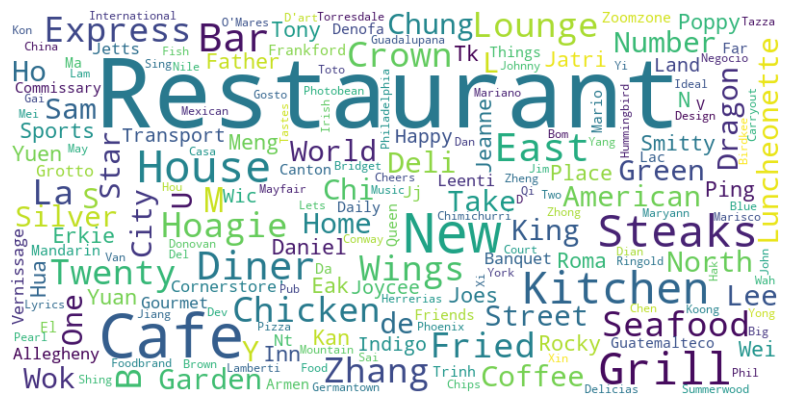

In [1034]:
restaurant_cloud = food_desc[food_desc["desc_1"] == "restaurants"]

# Concatenate all text in the column
text = ' '.join(restaurant_cloud['name'].dropna())

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [1035]:
# Define the mapping
keyword_mapping = {
    'yuen': 'chinese',
    'ping': 'chinese',
    'zhong': 'chinese',
    'china': 'chinese',
    "chinese": "chinese",
    'canton': 'chinese',
    'wok': 'chinese',
    'lee': 'chinese',
    'china': 'chinese',
    'zhang': 'chinese',
    'chung': 'chinese',
    'dragon': 'chinese',
    'meng': 'chinese',
    'xin': 'chinese',
    'hua': 'chinese',
    'ping': 'chinese',
    'hua': 'chinese',
    'meng': 'chinese',
    'yi': 'chinese',
    'xi': 'chinese',
    'lam': 'chinese',
    'zhang': 'chinese',
    'wei': 'chinese',
    'salad': 'salad',
    'pizza': 'pizza',
    'grill': 'grill',
    "steak": "grill",
    'sushi': 'japanese',
    'chicken': 'chicken',
    'pizzeria': 'pizza',
    'pizza': 'pizza',
    'bbg': 'bbq',
    'hoagie': 'sandwich',
    'steaks': 'sandwich',
    'coffee': 'cafe', 
    'cafe': 'cafe',
    'diner': 'american',
    'luncheonette': 'american',
    'wings': 'wings',
    'deli': 'deli',
    'mexican': 'latin',
    'guadalupana': 'latin',
    'guatamelteco': 'latin',
    'fish': 'seafood',
    'casa': 'latin'}

# Function to find the keyword and return the corresponding desc_2 value
def map_keyword_to_desc(name, mapping):
    for keyword, desc in mapping.items():
        if re.search(re.escape(keyword), name, re.IGNORECASE):
            return desc
    return None

# Define the list of specific values
specific_values = ["food trucks", "fooddeliveryservices", "bars", "grocery", "restaurants"]

# Define the combined condition: desc_2 is NA or in the list of specific values
condition_combined = food_desc['desc_2'].isna() | food_desc['desc_1'].isin(specific_values)

# Apply the function to update desc_2 based on the combined condition
food_desc.loc[condition_combined, 'desc_1'] = food_desc.loc[condition_combined, 'name'].apply(lambda x: map_keyword_to_desc(x, keyword_mapping))

### Identify fast food/chain restaurants
Override desc_1 with "fastfood" for major chain restaurants.

In [1036]:
food_desc.groupby("name").size().sort_values(ascending = False).head(10)

name
Wawa                         28
McDonald's                   25
Popeyes Louisiana Kitchen    19
Wendy's                      17
Philly Pretzel Factory       13
KFC                          13
Subway                       10
Wingstop                      9
Taco Bell                     9
Crown Fried Chicken           8
dtype: int64

In [1037]:
fast_food = [
    "McDonald's",
    "Wawa", 
    "Wingstop",
    "MrBeast Burger",
    "Chick-fil-A",
    "Chipotle Mexican Grill",
    "Checkers",
    "Wendy's",
    "Subway",
    "Popeyes Louisiana Kitchen",
    "Taco Bell",
    "KFC",
    "Burger King",
]

In [1038]:
food_desc.loc[food_desc["name"].isin(fast_food), "desc_1"] = "fastfood"

Take the descriptions with frequency < 6 and replace the string with the second term in alias

In [1039]:
desc_counts = food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

# Filter for 'desc_1' values where count is less than 6
desc_less_than_six = desc_counts[desc_counts['count'] < 6]['desc_1']

# Convert the filtered results to a list
desc_list = desc_less_than_six.tolist()

# replace desc_1 with desc_2 where desc_1 is in the list of descriptions with frequency < 6
food_desc.loc[food_desc['desc_1'].isin(desc_list), 'desc_1'] = food_desc['desc_2']

In [1040]:
food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

desc_1  count
83                  pizza    327
29                chinese    179
47               fastfood    162
95             sandwiches    117
96                seafood     92
11       breakfast_brunch     81
38                   deli     70
15                burgers     55
17                   cafe     52
65                italian     42
27          chicken_wings     38
51                  grill     37
94                  salad     37
97               soulfood     37
5                bakeries     36
31                 coffee     33
76                mexican     30
66               japanese     27
111          tradamerican     24
18                  cafes     24
25           cheesesteaks     24
57                hotdogs     23
75          mediterranean     23
23              caribbean     22
104                 sushi     20
26                chicken     19
53                  halal     19
42                 diners     18
7                     bbq     17
68              juicebars     16
72                  latin     16
30           cocktailbars     15
40               desserts     14
61                 indpak     13
69                 korean     13
116            vietnamese     13
115                venues     13
4             asianfusion     12
60               icecream     12
3                american     12
87               pretzels     12
39                  delis     12
77             mideastern     11
102                 steak     11
109                  thai     11
50             gastropubs     10
114            vegetarian      9
9                 beerbar      9
1                 african      9
41                 dimsum      9
105                 tacos      9
19                  cajun      9
113                 vegan      8
90                  ramen      8
120                 wings      7
45                 donuts      7
81                noodles      7
28            chickenshop      6
80            newamerican      6
101            sportsbars      4
22              cantonese      3
93                russian      3
8           beer_and_wine      3
74                markets      2
100               spanish      2
119           whiskeybars      2
79            musicvenues      2
82               pancakes      2
89                   pubs      2
84                 polish      2
0               acaibowls      2
121                 wraps      2
49                 french      2
24                 cheese      2
70                 kosher      2
63                  irish      2
37             danceclubs      2
43               divebars      2
59                iberian      2
56                 hotdog      2
46                falafel      2
103         streetvendors      1
21                  candy      1
106                 tapas      1
107       tapasmallplates      1
108               tex-mex      1
20              cambodian      1
16                burmese      1
110           themedcafes      1
33            convenience      1
112             ukrainian      1
14                buffets      1
13              bubbletea      1
12               brewpubs      1
10              brazilian      1
117               waffles      1
118           waterstores      1
6                    bars      1
2          airportlounges      1
32            comfortfood      1
71                laotian      1
34         cookingclasses      1
52                haitian      1
73                lounges      1
67           jazzandblues      1
64             irish_pubs      1
62            intlgrocery      1
78        modern_european      1
58                 hotpot      1
55          healthmarkets      1
54               hawaiian      1
85       popuprestaurants      1
99               southern      1
86             popupshops      1
88          publicmarkets      1
48   fooddeliveryservices      1
91                  reiki      1
92            restaurants      1
44              dominican      1
35              creperies      1
98                   soup 

In [1041]:
food_cats = food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)
top_food_cats = list(food_cats[food_cats["count"] >= 12]["desc_1"])
food_desc = food_desc[food_desc["desc_1"].isin(top_food_cats)]

### Sort into larger categories

In [1042]:
# Define the mapping dictionary
desc_mapping = {
    "burgers": "sandwiches/delis",
    "hotdogs": "sandwiches/delis",
    "chicken_wings": "chicken",
    "tradamerican": "american",
    "newamerican": "american",
    "wings": "chicken",
    "hotdog": "diner/grill",
    "gastropubs": "diner/grill",
    "diners": "diner/grill",
    "steak": "diner/grill",
    "grills": "diner/grill",
    "grill": "diner/grill",
    "coffee": "bakeries/cafes",
    'cafe': "bakeries/cafes",
    "cafes": "bakeries/cafes",
    'bagels': "bakeries/cafes",
    'wraps': "bakeries/cafes",
    'soups': "bakeries/cafes",
    'soup': "bakeries/cafes",
    "cupcakes": "bakeries/cafes",
    "creperies": "bakeries/cafes",
    "bakeries": "bakeries/cafes",
    "juicebars": "bakeries/cafes",
    'donuts': "bakeries/cafes",
    'icecream': "bakeries/cafes",
    "ice cream": 'bakeries/cafes',
    "desserts": "bakeries/cafes",
    "waffles": "bakeries/cafes",
    "cakeshop": "bakeries/cafes",
    'customcakes': 'bakeries/cafes',
    "cheesesteaks": "sandwiches/delis",
    "sandwich": "sandwiches/delis",
    "sandwiches": "sandwiches/delis",
    "delis": "sandwiches/delis",
    "deli": "sandwiches/delis",
    "chickenshop": "chicken",
    "sushi": "japanese",
    "ramen": "japanese",
    'hotpot': 'chinese',
    "szechuan": "chinese",
    "cantonese": "chinese",
    "dimsum": "chinese",
    "shanghainese": "chinese",
    "pretzels": "bakeries/cafes",
    "mexican": "latin",
    "honduran": "latin",
    "nicaraguan": "latin",
    "spanish": "latin",
    "guatemalan": "latin",
    "tacos": "latin",
    "brazilian": "latin",
    "portuguese": "latin",
    "dominican": "caribbean",
    "haitian": "caribbean",
    "seafoodmarket,": "seafood",
    "seafoodmarkets,": "seafood",
    "greek": "mediterranean",
    "mideastern": "halal"
}

# Replace desc_1 values using the mapping dictionary
food_desc['desc_1'] = food_desc['desc_1'].replace(desc_mapping)

In [1043]:
food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

desc_1  count
18             pizza    327
20  sandwiches/delis    301
2     bakeries/cafes    199
7            chinese    179
10          fastfood    162
21           seafood     92
4   breakfast_brunch     81
6            chicken     57
9        diner/grill     55
14          japanese     47
16             latin     46
13           italian     42
22          soulfood     37
19             salad     37
0           american     36
17     mediterranean     23
5          caribbean     22
11             halal     19
3                bbq     17
8       cocktailbars     15
23            venues     13
12            indpak     13
15            korean     13
24        vietnamese     13
1        asianfusion     12

In [1044]:
len(food_desc)

1858

## Parks

In [1045]:
# Filter and create a copy to avoid SettingWithCopyWarning
parks_desc = parks.copy()

# Create a new column 'desc_1'
parks_desc["desc_1"] = parks_desc['alias'].str.split(',').str[0].str.strip().str.lower()
parks_desc["desc_2"] = parks_desc['alias'].str.split(',').str[1].str.strip().str.lower()
parks_desc["desc_3"] = parks_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### First word in 'alias'

In [1046]:
# Group by 'desc_1' and count, then convert to DataFrame
parks_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(100)

desc_1  count
19               parks    150
15           landmarks     36
21         playgrounds     25
7            dog_parks     23
13              hiking     17
24          recreation      9
12             gardens      7
25         skate_parks      6
28              tennis      4
11            football      4
3     basketballcourts      2
6             discgolf      2
14     kids_activities      2
17             museums      2
18           nonprofit      2
23             rafting      2
20                pets      1
26      stadiumsarenas      1
22           publicart      1
27       swimmingpools      1
0   amateursportsteams      1
16         localflavor      1
1                 bars      1
10             fishing      1
9                farms      1
8        farmersmarket      1
5             climbing      1
4                bikes      1
2       baseballfields      1
29             theater      1

### Filter for categories where frequency ≥ 5

In [1047]:
park_desc_1 = parks_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(9)
top_park_desc = list(park_desc_1["desc_1"])
# remove historical landmarks
top_park_desc.remove('landmarks')

# filter for obs in the list of top descriptions
parks_desc = parks_desc[parks_desc["desc_1"].isin(top_park_desc)]
parks_desc.head(10)

name  rating                  address  \
0                     Cedar Park     4.5  50th St & Baltimore Ave   
1        Chester Avenue Dog Park     3.5            801 S 48th St   
2                 Malcolm X Park     4.0         51ST And Pine St   
3                    Barkan Park     3.0           4936 Spruce St   
4            Clark Park Dog Bowl     4.5           43rd & Chester   
5                     Clark Park     4.5       43RD And Baltimore   
6  Greys Ferry Cresent Skatepark     5.0     3600 Grays Ferry Ave   
7           Grays Ferry Crescent     4.0                            
8                Lanier Dog Park     4.0           2911 Tasker St   
9                Saunder's Green     3.5      300-50 Saunders Ave   

                alias               title                        geometry  \
0               parks               Parks  POINT (2677006.643 234133.514)   
1           dog_parks           Dog Parks  POINT (2678024.964 234174.704)   
2               parks               Parks  POINT (2676187.013 235721.062)   
3  parks, playgrounds  Parks, Playgrounds  POINT (2677109.530 236278.545)   
4           dog_parks           Dog Parks  POINT (2680815.785 234312.734)   
5               parks               Parks  POINT (2680756.007 234729.865)   
6         skate_parks         Skate Parks  POINT (2683004.637 231400.562)   
7               parks               Parks  POINT (2682813.782 232182.835)   
8           dog_parks           Dog Parks  POINT (2685221.027 229056.524)   
9               parks               Parks  POINT (2683400.920 238616.685)   

        desc_1       desc_2 desc_3  
0        parks          NaN    NaN  
1    dog_parks          NaN    NaN  
2        parks          NaN    NaN  
3        parks  playgrounds    NaN  
4    dog_parks          NaN    NaN  
5        parks          NaN    NaN  
6  skate_parks          NaN    NaN  
7        parks          NaN    NaN  
8    dog_parks          NaN    NaN  
9        parks          NaN    NaN

## Education

In [1048]:
# Filter and create a copy to avoid SettingWithCopyWarning
edu_desc = education.copy()

# Create a new column 'desc_1'
edu_desc["desc_1"] = edu_desc['alias'].str.split(',').str[0].str.strip().str.lower()
edu_desc["desc_2"] = edu_desc['alias'].str.split(',').str[1].str.strip().str.lower()
edu_desc["desc_3"] = edu_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### First word in alias

In [1049]:
# Group by 'desc_1' and count, then convert to DataFrame
edu_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

desc_1  count
14            childcare     91
29    elementaryschools     86
66           preschools     62
17          collegeuniv     55
43          highschools     33
26      driving_schools     31
28    educationservices     25
75     specialtyschools     23
81              theater     17
6            artschools     15
19  cosmetology_schools     14
83             tutoring     13
3            artclasses     13
27            education     12
22        dance_schools     10
86             vocation      9
23          dancestudio      8
68        privatetutors      7
49           montessori      7
20           cprclasses      7

### Filter for frequency ≥ 6

In [1050]:
edu_desc_1 = edu_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(18)
top_edu_desc = list(edu_desc_1["desc_1"])
# remove historical landmarks
top_edu_desc.remove('theater')

# filter for obs in the list of top descriptions
edu_desc_1 = edu_desc[edu_desc["desc_1"].isin(top_edu_desc)]
edu_desc.head(10)

name  rating             address  \
0                            BellyWise     5.0                 NaN   
1                        Limitless CPR     5.0                 NaN   
2                        Michele Judge     5.0   4919 Pentridge St   
3  Kipp West Philadelphia Prep Charter     1.0  5900 Baltimore Ave   
4  Beulah Baptist Christian Day School     2.0      5001 Spruce St   
5      The Academy of Industrial Arts      5.0   6328 Paschall Ave   
6                                TYLII     3.0      5124 Walnut St   
7           University of the Sciences     3.0       600 S 43rd St   
8                All Around This World     5.0        4336 Pine St   
9                       Jubilee School     3.0    4211 Chester Ave   

                                alias  \
0          midwives, specialtyschools   
1                          cprclasses   
2  jewelryrepair, artclasses, jewelry   
3                           specialed   
4       elementaryschools, preschools   
5              vocation, electricians   
6               preschools, childcare   
7                         collegeuniv   
8                   educationservices   
9                         highschools   

                                         title  \
0                  Midwives, Specialty Schools   
1                                  CPR Classes   
2         Jewelry Repair, Art Classes, Jewelry   
3                            Special Education   
4               Elementary Schools, Preschools   
5  Vocational & Technical School, Electricians   
6            Preschools, Child Care & Day Care   
7                      Colleges & Universities   
8                         Educational Services   
9                Middle Schools & High Schools   

                         geometry             desc_1            desc_2  \
0  POINT (2676169.939 231988.984)           midwives  specialtyschools   
1  POINT (2677042.522 231394.414)         cprclasses               NaN   
2  POINT (2677304.635 233898.273)      jewelryrepair        artclasses   
3  POINT (2671666.162 232636.864)          specialed               NaN   
4  POINT (2677065.563 236331.076)  elementaryschools        preschools   
5  POINT (2674851.743 225884.662)           vocation      electricians   
6  POINT (2676415.568 237130.841)         preschools         childcare   
7  POINT (2681062.408 233555.127)        collegeuniv               NaN   
8  POINT (2680347.395 235381.376)  educationservices               NaN   
9  POINT (2681043.809 234475.721)        highschools               NaN   

    desc_3  
0      NaN  
1      NaN  
2  jewelry  
3      NaN  
4      NaN  
5      NaN  
6      NaN  
7      NaN  
8      NaN  
9      NaN

## Grocery

In [1051]:
# Filter and create a copy to avoid SettingWithCopyWarning
grocery_desc = grocery.copy()

# Create a new column 'desc_1'
grocery_desc["desc_1"] = grocery_desc['alias'].str.split(',').str[0].str.strip().str.lower()
grocery_desc["desc_2"] = grocery_desc['alias'].str.split(',').str[1].str.strip().str.lower()
grocery_desc["desc_3"] = grocery_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [1052]:
grocery_desc.head()

name  rating             address  \
0  Kim A Grocery & Deli     1.0      1840 S 58th St   
1       S and J Seafood     4.0       713 S 52nd St   
2   Mariposa Food Co-op     4.0  4824 Baltimore Ave   
3      Jennifer Grocery     2.5    4824 Chester Ave   
4    Fu-Wah Mini Market     4.5       810 S 47th St   

                              alias                                    title  \
0                           grocery                                  Grocery   
1           seafoodmarkets, grocery                 Seafood Markets, Grocery   
2            grocery, healthmarkets                  Grocery, Health Markets   
3              grocery, convenience              Grocery, Convenience Stores   
4  convenience, sandwiches, grocery  Convenience Stores, Sandwiches, Grocery   

                         geometry          desc_1         desc_2   desc_3  
0  POINT (2675396.135 229529.164)         grocery            NaN      NaN  
1  POINT (2675793.250 234207.384)  seafoodmarkets        grocery      NaN  
2  POINT (2677563.153 234052.277)         grocery  healthmarkets      NaN  
3  POINT (2678754.671 232771.760)         grocery    convenience      NaN  
4  POINT (2678571.989 234207.924)     convenience     sandwiches  grocery

## Nightlife

In [1053]:
# Filter and create a copy to avoid SettingWithCopyWarning
night_desc = nightlife.copy()

# Create a new column 'desc_1'
night_desc["desc_1"] = night_desc['alias'].str.split(',').str[0].str.strip().str.lower()
night_desc["desc_2"] = night_desc['alias'].str.split(',').str[1].str.strip().str.lower()
night_desc["desc_3"] = night_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [1054]:
night_desc.head()

name  rating             address  \
0  Pentridge Station Beer Garden     4.5  5116  Pentridge St   
1                     720 Bistro     4.0       720 S.52nd st   
2                          Bayou     4.5  5025 Baltimore Ave   
3    Booker's Restaurant and Bar     3.5  5021 Baltimore Ave   
4                The Wine Garden     4.5  5019 Baltimore Ave   

                                     alias  \
0                              beergardens   
1  seafood, breakfast_brunch, cocktailbars   
2                                  lounges   
3     bars, breakfast_brunch, tradamerican   
4                                wine_bars   

                                        title                        geometry  \
0                                Beer Gardens  POINT (2676581.781 233167.788)   
1  Seafood, Breakfast & Brunch, Cocktail Bars  POINT (2675620.054 234102.746)   
2                                     Lounges  POINT (2676525.799 234061.840)   
3          Bars, Breakfast & Brunch, American  POINT (2676559.222 234070.085)   
4                                   Wine Bars  POINT (2676563.551 234060.148)   

        desc_1            desc_2        desc_3  
0  beergardens               NaN           NaN  
1      seafood  breakfast_brunch  cocktailbars  
2      lounges               NaN           NaN  
3         bars  breakfast_brunch  tradamerican  
4    wine_bars               NaN           NaN

### Alias

In [1055]:
# Group by 'desc_1' and count, then convert to DataFrame
night_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
6            bars    172
86     sportsbars     78
75           pubs     71
34       divebars     53
61        lounges     49
100  tradamerican     49
67    newamerican     47
23   cocktailbars     39
47    hookah_bars     28
66    musicvenues     28

In [1056]:
# Group by 'desc_2' and count, then convert to DataFrame
night_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_2  count
7            bars     93
103  tradamerican     61
93     sportsbars     48
25   cocktailbars     43
69    newamerican     39
62        lounges     28
86        seafood     28
68    musicvenues     25
80           pubs     24
11        beerbar     19

In [1057]:
# Group by 'desc_3' and count, then convert to DataFrame
night_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_3  count
17      cocktailbars     51
70      tradamerican     39
3               bars     24
8   breakfast_brunch     21
6            beerbar     20
72            venues     17
10           burgers     17
56        sandwiches     15
48       musicvenues     12
62        sportsbars     12

### Replace desc_1 with more relevant alias terms

In [1058]:
# replace desc_2
condition1 = night_desc['desc_2'].isin(["newamerican", "seafood", "breakfast_brunch", "tradamerican", "burgers", "sandwiches", "pizza", "mexican", "italian",
                                       "french", "ramen", "tapasmallplates", "french", "ramen", "mideastern", "comfortfood", "steak", "mediterranean", "caribbean",
                                       "bbq", "peruvian", "japanese", "ethiopian", "tex-mex", "southern", "juicebars", "cajun", "soulfood", "portugeuse", "sushi",
                                       "vegan", "cafes", "diners", "chicken-wings", "chinese", "salad", "cheesesteaks", "african", "german", "desserts", "indpak",
                                       "thai", "tacos", "falafel", "vietnamese", "waffles", "delis", "coffee", "korean", "hotdog", "moroccan", "newmexican", "cuban",
                                       "argentine", "gluten_free", "russian", "bakeries", "portuguese", "spanish", "latin", "catering", "gastropubs", 
                                       "breweries", "gaybars", "whiskeybars", "tikibars", "tobaccoshops", "beer_and_wine", "breweries", "venues",
                                       "poolhalls", "jazzandblues", "airportlounges", "cigarbars", "speakeasies", "theater", "nightlife"])

condition2 = night_desc['desc_3'].notna()

# Update desc_1 where conditions are met
night_desc.loc[condition1 & condition2, 'desc_2'] = night_desc['desc_3']


# replace desc_1
condition1 = night_desc['desc_1'].isin(["newamerican", "seafood", "breakfast_brunch", "tradamerican", "burgers", "sandwiches", "pizza", "mexican", "italian",
                                       "french", "ramen", "tapasmallplates", "french", "ramen", "mideastern", "comfortfood", "steak", "mediterranean", "caribbean",
                                       "bbq", "peruvian", "japanese", "ethiopian", "tex-mex", "southern", "juicebars", "cajun", "soulfood", "portugeuse", "sushi",
                                       "vegan", "cafes", "diners", "chicken-wings", "chinese", "salad", "cheesesteaks", "african", "german", "desserts", "indpak",
                                       "thai", "tacos", "falafel", "vietnamese", "waffles", "delis", "coffee", "korean", "hotdog", "moroccan", "newmexican", "cuban",
                                       "argentine", "gluten_free", "russian", "bakeries", "portuguese", "spanish", "latin", "catering", "gastropubs", 
                                       "breweries", "gaybars", "whiskeybars", "tikibars", "tobaccoshops", "beer_and_wine", "breweries", "venues",
                                       "poolhalls", "jazzandblues", "airportlounges", "cigarbars", "speakeasies", "theater", "nightlife"])

condition2 = night_desc['desc_2'].notna()

# Update desc_1 where conditions are met
night_desc.loc[condition1 & condition2, 'desc_1'] = night_desc['desc_2']

night_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(15)

desc_1  count
4             bars    271
51      sportsbars    114
12    cocktailbars    105
45            pubs     86
39         lounges     64
20        divebars     60
6          beerbar     44
61       wine_bars     42
40     musicvenues     42
31     hookah_bars     36
17      danceclubs     32
34      irish_pubs     14
37         karaoke     13
7      beergardens     12
0   airportlounges      9

### Filter for categories where frequency ≥ 8

In [1059]:
night_desc_1 = night_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(9)
top_night_desc = list(night_desc_1["desc_1"])

# filter for obs in the list of top descriptions
night_desc = night_desc[night_desc["desc_1"].isin(top_night_desc)]
night_desc.head(10)

name  rating             address  \
1                             720 Bistro     4.0       720 S.52nd st   
2                                  Bayou     4.5  5025 Baltimore Ave   
3            Booker's Restaurant and Bar     3.5  5021 Baltimore Ave   
4                        The Wine Garden     4.5  5019 Baltimore Ave   
5                            Carbon Copy     4.5       701 S 50th St   
6   Dock Street Cannery and Tasting Room     4.0       705 S 50th St   
7              Trendsetters Bar & Lounge     3.5   5301 Woodland Ave   
8                               The Barn     3.5   4901 Catharine St   
9                            Eris Temple     4.0       602 S 52nd St   
10                                Dahlak     3.5  4708 Baltimore Ave   

                                      alias  \
1   seafood, breakfast_brunch, cocktailbars   
2                                   lounges   
3      bars, breakfast_brunch, tradamerican   
4                                 wine_bars   
5                    breweries, pizza, bars   
6                          beerbar, lounges   
7                   burgers, lounges, wraps   
8           poolhalls, sportsbars, divebars   
9                               musicvenues   
10                      ethiopian, divebars   

                                         title  \
1   Seafood, Breakfast & Brunch, Cocktail Bars   
2                                      Lounges   
3           Bars, Breakfast & Brunch, American   
4                                    Wine Bars   
5                       Breweries, Pizza, Bars   
6                            Beer Bar, Lounges   
7                      Burgers, Lounges, Wraps   
8           Pool Halls, Sports Bars, Dive Bars   
9                                 Music Venues   
10                        Ethiopian, Dive Bars   

                          geometry        desc_1        desc_2        desc_3  
1   POINT (2675620.054 234102.746)  cocktailbars  cocktailbars  cocktailbars  
2   POINT (2676525.799 234061.840)       lounges           NaN           NaN  
3   POINT (2676559.222 234070.085)          bars  tradamerican  tradamerican  
4   POINT (2676563.551 234060.148)     wine_bars           NaN           NaN  
5   POINT (2676997.957 233927.765)          bars          bars          bars  
6   POINT (2677046.168 233912.738)       beerbar       lounges           NaN  
7   POINT (2678439.957 230236.502)       lounges       lounges         wraps  
8   POINT (2677365.738 234212.623)    sportsbars    sportsbars      divebars  
9   POINT (2675702.055 234852.608)   musicvenues           NaN           NaN  
10  POINT (2678487.076 234234.642)      divebars      divebars           NaN

## Entertainment

In [1060]:
# Filter and create a copy to avoid SettingWithCopyWarning
entertain_desc = entertainment.copy()

# Create a new column 'desc_1'
entertain_desc["desc_1"] = entertain_desc['alias'].str.split(',').str[0].str.strip().str.lower()
entertain_desc["desc_2"] = entertain_desc['alias'].str.split(',').str[1].str.strip().str.lower()
entertain_desc["desc_3"] = entertain_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [1061]:
entertain_desc.head()

name  rating             address  \
0                     Noam Osband     5.0                 NaN   
1                 Ceramic Concept     5.0  5015 Baltimore Ave   
2                     Eris Temple     4.0       602 S 52nd St   
3  Baltimore Avenue Dollar Stroll     5.0  4800 Baltimore Ave   
4           Curio Theatre Company     4.5       815 S 48th St   

                             alias                              title  \
0                        musicians                          Musicians   
1                        galleries                      Art Galleries   
2                      musicvenues                       Music Venues   
3  unofficialyelpevents, festivals  Unofficial Yelp Events, Festivals   
4                          theater                    Performing Arts   

                         geometry                desc_1     desc_2 desc_3  
0  POINT (2676083.283 232370.886)             musicians        NaN    NaN  
1  POINT (2676620.711 234054.592)             galleries        NaN    NaN  
2  POINT (2675702.055 234852.608)           musicvenues        NaN    NaN  
3  POINT (2677842.004 234135.971)  unofficialyelpevents  festivals    NaN  
4  POINT (2678192.432 234160.959)               theater        NaN    NaN

### Alias

In [1062]:
# Group by 'desc_1' and count, then convert to DataFrame
entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
130        theater    127
53       galleries     96
50       festivals     69
86         museums     42
42             djs     28
89     musicvenues     28
105       psychics     23
85   movietheaters     20
117   social_clubs     19
47   eventplanning     16

In [1063]:
entertain_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_2  count
45       galleries     32
80     musicvenues     25
116        theater     24
119         venues     19
35     dancestudio     14
39   eventplanning     11
34      danceclubs     10
75   movietheaters     10
4          arcades      9
14            bars      8

In [1064]:
entertain_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_3  count
59      musicvenues     13
92           venues      9
25    dance_schools      6
27      dancestudio      5
58        musicians      5
34    eventplanning      5
49  kids_activities      5
2           arcades      4
3        artclasses      4
89          theater      4

### Replace desc_1 with more relevant alias terms

In [1065]:
# replace desc_2
condition1 = entertain_desc['desc_2'].isin(["arts", "musicians", "kids_activities", "venues", "bars", "nonprofit", "lounges"])

condition2 = entertain_desc['desc_3'].notna()

# Update desc_1 where conditions are met
entertain_desc.loc[condition1 & condition2, 'desc_2'] = entertain_desc['desc_3']


# replace desc_1
condition1 = entertain_desc['desc_1'].isin(["arts", "musicians", "kids_activities", "venues", "bars", "nonprofit", "lounges"])

condition2 = entertain_desc['desc_2'].notna()

# Update desc_1 where conditions are met
entertain_desc.loc[condition1 & condition2, 'desc_1'] = entertain_desc['desc_2']

entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(40)

desc_1  count
131                theater    130
55               galleries     98
52               festivals     70
87                 museums     42
90             musicvenues     34
43                     djs     29
118           social_clubs     24
106               psychics     23
86           movietheaters     21
48           eventplanning     17
39              danceclubs     16
35            countryclubs     11
57                 gardens     10
7               artmuseums     10
104      psychic_astrology      9
40             dancestudio      9
95             paintandsip      9
125         stadiumsarenas      9
8                     arts      8
17                 bowling      8
5                  arcades      8
100      photoboothrentals      8
124            sportsteams      7
6               artclasses      7
37          culturalcenter      7
32             comedyclubs      6
105         psychicmediums      6
91             newamerican      6
82               magicians      5
71            jazzandblues      5
27                catering      5
26                 casinos      5
15                   bingo      5
54                 framing      4
122       specialtyschools      4
123             sportsbars      4
0                               4
98   partyequipmentrentals      4
28                  clowns      4
9            artsandcrafts      3

### Filter for frequency 

In [1066]:
entertain_desc_1 = entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)
entertain_desc_1 = entertain_desc_1[entertain_desc_1['count'] >= 5]

top_entertain_desc = list(entertain_desc_1["desc_1"])


top_entertain_desc.remove('psychics')

# filter for obs in the list of top descriptions
entertain_desc = entertain_desc[entertain_desc["desc_1"].isin(top_entertain_desc)]

In [1067]:
entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

desc_1  count
31            theater    130
16          galleries     98
15          festivals     70
21            museums     42
22        musicvenues     34
13                djs     29
28       social_clubs     24
20      movietheaters     21
14      eventplanning     17
11         danceclubs     16
9        countryclubs     11
2          artmuseums     10
17            gardens     10
12        dancestudio      9
24        paintandsip      9
30     stadiumsarenas      9
26  psychic_astrology      9
25  photoboothrentals      8
5             bowling      8
3                arts      8
0             arcades      8
10     culturalcenter      7
1          artclasses      7
29        sportsteams      7
23        newamerican      6
27     psychicmediums      6
8         comedyclubs      6
19          magicians      5
7            catering      5
6             casinos      5
18       jazzandblues      5
4               bingo      5

In [1068]:
# Define the mapping dictionary
desc_mapping = {
    "djs": "nightclubs",
    "danceclubs": "nightclubs",
    "artmuseums": "museums",
    "sportsteams": "sports",
    "stadiumsarenas": "sports",
    "paintandsip": "specialtyclasses",
    "dancestudio": "specialtyclasses",
    "bowling": "games/arcade",
    "bingo": "games/arcade",
    "arcades": "games/arcade",
    "artclasses": "specialtyclasses"
}

# Replace desc_1 values using the mapping dictionary
entertain_desc.loc[:, 'desc_1'] = entertain_desc['desc_1'].replace(desc_mapping)

In [1069]:
entertain_cat = entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)
entertain_cat_top = list(entertain_cat[entertain_cat["count"] >= 11]["desc_1"])
# filter for desc_1
entertain_desc = entertain_desc[entertain_desc["desc_1"].isin(entertain_cat_top)]
entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

desc_1  count
12           theater    130
3          galleries     98
2          festivals     70
6            museums     52
8         nightclubs     45
7        musicvenues     34
10  specialtyclasses     25
9       social_clubs     24
4       games/arcade     21
5      movietheaters     21
1      eventplanning     17
11            sports     16
0       countryclubs     11

## Shopping

In [1070]:
# Filter and create a copy to avoid SettingWithCopyWarning
shop_desc = shopping.copy()

# Create a new column 'desc_1'
shop_desc["desc_1"] = shop_desc['alias'].str.split(',').str[0].str.strip().str.lower()
shop_desc["desc_2"] = shop_desc['alias'].str.split(',').str[1].str.strip().str.lower()
shop_desc["desc_3"] = shop_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [1071]:
shop_desc.head()

name  rating                address  \
0                                Rite Aid     2.0  5214-30 Baltimore Ave   
1  Ajah Creative Sweets And Treats & More     5.0                    NaN   
2                         Ceramic Concept     5.0     5015 Baltimore Ave   
3                            VIX Emporium     4.5     5009 Baltimore Ave   
4                           Michele Judge     5.0      4919 Pentridge St   

                                alias  \
0             drugstores, convenience   
1       desserts, cupcakes, giftshops   
2                           galleries   
3  artsandcrafts, childcloth, jewelry   
4  jewelryrepair, artclasses, jewelry   

                                         title  \
0               Drugstores, Convenience Stores   
1               Desserts, Cupcakes, Gift Shops   
2                                Art Galleries   
3  Arts & Crafts, Children's Clothing, Jewelry   
4         Jewelry Repair, Art Classes, Jewelry   

                         geometry         desc_1       desc_2     desc_3  
0  POINT (2675264.630 233732.096)     drugstores  convenience        NaN  
1  POINT (2677939.712 232732.831)       desserts     cupcakes  giftshops  
2  POINT (2676620.711 234054.592)      galleries          NaN        NaN  
3  POINT (2676676.410 234091.659)  artsandcrafts   childcloth    jewelry  
4  POINT (2677304.635 233898.273)  jewelryrepair   artclasses    jewelry

### Alias

In [1072]:
# Group by 'desc_1' and count, then convert to DataFrame
shop_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
32      drugstores    234
142    womenscloth    114
69         jewelry     90
31   discountstore     87
49       galleries     84
48       furniture     74
113          shoes     68
29      deptstores     56
86       menscloth     50
11      bookstores     41

In [1073]:
# Group by 'desc_2' and count, then convert to DataFrame
shop_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_2  count
24     convenience     95
0      accessories     67
139    womenscloth     66
81       menscloth     51
48       furniture     38
65         jewelry     35
100       pharmacy     34
35   discountstore     32
49       galleries     29
61       homedecor     27

In [1074]:
# Group by desc_3' and count, then convert to DataFrame
shop_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_3  count
21   convenience     55
0    accessories     30
115  womenscloth     28
54     homedecor     26
79      pharmacy     23
95    sportswear     18
92         shoes     18
56       jewelry     18
15    childcloth     16
108      vintage     15

### Filter for most common labels

In [1075]:
shop_desc_1 = shop_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)
top_shop_desc = list(shop_desc_1["desc_1"])
top_shop_desc

['drugstores',
 'womenscloth',
 'jewelry',
 'discountstore',
 'galleries',
 'furniture',
 'shoes',
 'deptstores',
 'menscloth',
 'bookstores',
 'accessories',
 'thrift_stores',
 'antiques',
 'grocery',
 'giftshops',
 'homedecor',
 'selfstorage',
 'childcloth',
 'sportswear',
 'vintage']

In [1076]:
# remove drugstores and grocery
top_shop_desc.remove('drugstores')
top_shop_desc.remove('grocery')

# filter for obs in the list of top descriptions
shop_desc = shop_desc[shop_desc["desc_1"].isin(top_shop_desc)]

In [1077]:
# Define the mapping dictionary
desc_mapping = {
    "mattresses": "furniture",
    "kitchenandbath": "furniture",
    "rugs": "homedecor",
    "hats": "accessories",
    "watch_repair": "accessories"
}

# Replace desc_1 values using the mapping dictionary
shop_desc.loc[:, 'desc_1'] = shop_desc['desc_1'].replace(desc_mapping)
shop_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

desc_1  count
17    womenscloth    114
10        jewelry     90
5   discountstore     87
7       galleries     84
6       furniture     74
13          shoes     68
4      deptstores     56
11      menscloth     50
2      bookstores     41
0     accessories     40
15  thrift_stores     36
1        antiques     31
8       giftshops     24
12    selfstorage     23
9       homedecor     23
3      childcloth     21
14     sportswear     20
16        vintage     19

## Healthcare

In [1078]:
# Filter and create a copy to avoid SettingWithCopyWarning
health_desc = healthcare.copy()

# Create a new column 'desc_1'
health_desc["desc_1"] = health_desc['alias'].str.split(',').str[0].str.strip().str.lower()
health_desc["desc_2"] = health_desc['alias'].str.split(',').str[1].str.strip().str.lower()
health_desc["desc_3"] = health_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### Alias

In [1079]:
# Group by 'desc_1' and count, then convert to DataFrame
health_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
38  laboratorytesting     33
80        urgent_care     26
33     homehealthcare     25
43         medcenters     23
29   generaldentistry     21
35          hospitals     20
37        internalmed     19
21         drugstores     19
26           familydr     16
11      chiropractors     14

### Filter for most common labels

In [1080]:
health_desc_1 = health_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)
top_health_desc = list(shop_desc_1["desc_1"])
top_health_desc

['drugstores',
 'womenscloth',
 'jewelry',
 'discountstore',
 'galleries',
 'furniture',
 'shoes',
 'deptstores',
 'menscloth',
 'bookstores',
 'accessories',
 'thrift_stores',
 'antiques',
 'grocery',
 'giftshops',
 'homedecor',
 'selfstorage',
 'childcloth',
 'sportswear',
 'vintage']

In [1081]:
# filter for obs in the list of top descriptions
health_desc = health_desc[health_desc["desc_1"].isin(top_health_desc)]

## Historic landmarks

In [1082]:
# Filter and create a copy to avoid SettingWithCopyWarning
historic_desc = historic.copy()

# Create a new column 'desc_1'
historic_desc["desc_1"] = historic_desc['alias'].str.split(',').str[0].str.strip().str.lower()
historic_desc["desc_2"] = historic_desc['alias'].str.split(',').str[1].str.strip().str.lower()
historic_desc["desc_3"] = historic_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### Alias

In [1083]:
# Group by 'desc_1' and count, then convert to DataFrame
historic_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
1      landmarks     46
4        museums     25
0     artmuseums      2
2      libraries      2
9         venues      2
3   municipality      1
5      nonprofit      1
6    postoffices      1
7      publicart      1
8  religiousorgs      1

### Filter for most common labels

In [1084]:
historic_desc_1 = historic_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(3)
top_historic_desc = list(historic_desc_1["desc_1"])
top_historic_desc

['landmarks', 'museums', 'artmuseums']

In [1085]:
# filter for obs in the list of top descriptions
historic_desc = historic_desc[historic_desc["desc_1"].isin(top_historic_desc)]

In [1086]:
# Define the mapping dictionary
desc_mapping = {
    "artmuseums": "museums"
}

# Replace desc_1 values using the mapping dictionary
historic_desc['desc_1'] = historic_desc['desc_1'].replace(desc_mapping)
historic_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

desc_1  count
0  landmarks     46
1    museums     27

## Kids activities

In [1087]:
kids_desc = kids.copy()

# Create a new column 'desc_1'
kids_desc["desc_1"] = kids_desc['alias'].str.split(',').str[0].str.strip().str.lower()
kids_desc["desc_2"] = kids_desc['alias'].str.split(',').str[1].str.strip().str.lower()
kids_desc["desc_3"] = kids_desc['alias'].str.split(',').str[2].str.strip().str.lower()

kids_desc.head()

name  rating                  address  \
0  Makono African Hair Braiding     3.0       5529 Baltimore Ave   
1                   Carbon Copy     4.5            701 S 50th St   
2            Firehouse Bicycles     4.5            701 S 50th St   
3             Common Beat Music     4.0       4916 Baltimore Ave   
4                    Cedar Park     4.5  50th St & Baltimore Ave   

                                                       alias  \
0                                    hairstylists, cosmetics   
1                                     breweries, pizza, bars   
2                             bikes, bike_repair_maintenance   
3  vinyl_records, electronicsrepair, musicinstrumentservices   
4                                                      parks   

                                                            title  \
0                        Hair Stylists, Cosmetics & Beauty Supply   
1                                          Breweries, Pizza, Bars   
2                                  Bikes, Bike Repair/Maintenance   
3  Vinyl Records, Electronics Repair, Musical Instrument Services   
4                                                           Parks   

                         geometry         desc_1                   desc_2  \
0  POINT (2673677.520 233714.490)   hairstylists                cosmetics   
1  POINT (2676997.957 233927.765)      breweries                    pizza   
2  POINT (2677005.367 233951.502)          bikes  bike_repair_maintenance   
3  POINT (2677188.738 233998.088)  vinyl_records        electronicsrepair   
4  POINT (2677006.643 234133.514)          parks                      NaN   

                    desc_3  
0                      NaN  
1                     bars  
2                      NaN  
3  musicinstrumentservices  
4                      NaN

### Alias

In [1088]:
# Group by 'desc_1' and count, then convert to DataFrame
kids_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
45           childcare     92
232              parks     53
131   generaldentistry     39
87          drugstores     36
141               gyms     34
255         preschools     29
311            theater     26
95   elementaryschools     26
189          libraries     26
107          festivals     25

In [1089]:
kids_desc = kids_desc[kids_desc["desc_1"].isin(["childcare", "parks", "preschools", "theater", "libraries", "festivals", "museums", 
                                                "martialarts", "churches", "playgrounds", "musicalinstrumentsandteachers", "landmarks", 
                                                "kids_activities"])]

In [1090]:
kids_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

desc_1  count
0                       childcare     92
9                           parks     53
11                     preschools     29
5                       libraries     26
12                        theater     26
2                       festivals     25
7                         museums     19
1                        churches     18
6                     martialarts     18
10                    playgrounds     18
8   musicalinstrumentsandteachers     17
4                       landmarks     15
3                 kids_activities     13

## Art and music

In [1091]:
arts_desc = arts.copy()

# Create a new column 'desc_1'
arts_desc["desc_1"] = arts_desc['alias'].str.split(',').str[0].str.strip().str.lower()
arts_desc["desc_2"] = arts_desc['alias'].str.split(',').str[1].str.strip().str.lower()
arts_desc["desc_3"] = arts_desc['alias'].str.split(',').str[2].str.strip().str.lower()

arts_desc.head()

name  rating             address  \
0     Curio Theatre Company     4.5       815 S 48th St   
1                 Studio 34     4.5  4522 Baltimore Ave   
2  Painted Bride Art Center     3.5      5212 Market St   
3               The Rotunda     4.5      4014 Walnut St   
4            Penn Live Arts     4.0      3680 Walnut St   

                                alias  \
0                             theater   
1              yoga, pilates, theater   
2                     theater, venues   
3                musicvenues, theater   
4  theater, jazzandblues, musicvenues   

                                         title  \
0                              Performing Arts   
1               Yoga, Pilates, Performing Arts   
2       Performing Arts, Venues & Event Spaces   
3                Music Venues, Performing Arts   
4  Performing Arts, Jazz & Blues, Music Venues   

                         geometry       desc_1        desc_2       desc_3  
0  POINT (2678192.432 234160.959)      theater           NaN          NaN  
1  POINT (2679553.196 234477.061)         yoga       pilates      theater  
2  POINT (2676029.704 238278.040)      theater        venues          NaN  
3  POINT (2682266.656 236480.866)  musicvenues       theater          NaN  
4  POINT (2684326.329 236037.832)      theater  jazzandblues  musicvenues

### Alias

In [1092]:
# Group by 'desc_1' and count, then convert to DataFrame
arts_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
27                        theater    163
7                     dancestudio     11
18  musicalinstrumentsandteachers     11
12                      galleries      9
20                    musicvenues      6
19                      musicians      5
11                      festivals      5
6                   dance_schools      5
3                      artschools      4
1                      artmuseums      4

### Regroup into large categories

In [1093]:
# Define the mapping dictionary
desc_mapping = {
    "specialtyschools": "classes",
    "dance_schools": "classes",
    "artschools": "classes",
    "musicalinstrumentsandteachers": "classes",
    "dancestudio": "dancestudios",
    "galleries": "gallery/museum",
    "museums": "gallery/museum",
    "artmuseums": "gallery/museum",
    "festivals": "events/shows",
    "jazzandblues": "events/shows",
    "djs": "events/shows",
    "musicvenues": "events/shows",
    "comedyclubs": "events/shows",
    "magicians": "events/shows",
    "musicians": "events/shows"
}

# Replace desc_1 values using the mapping dictionary
arts_desc['desc_1'] =arts_desc['desc_1'].replace(desc_mapping)
arts_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

desc_1  count
16            theater    163
7        events/shows     24
2             classes     22
8      gallery/museum     15
4        dancestudios     11
3      culturalcenter      2
0       aerialfitness      1
12              opera      1
17             venues      1
15       summer_camps      1
14       social_clubs      1
13         preschools      1
9                hair      1
11          nonprofit      1
10   language_schools      1
1                arts      1
6   educationservices      1
5       dinnertheater      1
18               yoga      1

### Filter for most common labels

In [1094]:
arts_desc_1 = arts_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)
top_arts_desc = list(arts_desc_1["desc_1"])

# remove historical landmarks
top_arts_desc.remove('summer_camps')
top_arts_desc.remove('preschools')
top_arts_desc.remove('language_schools')
top_arts_desc.remove('educationservices')

top_arts_desc

['theater',
 'events/shows',
 'classes',
 'gallery/museum',
 'dancestudios',
 'culturalcenter',
 'aerialfitness',
 'opera',
 'venues',
 'social_clubs',
 'hair',
 'nonprofit',
 'arts',
 'dinnertheater',
 'yoga']

In [1095]:
arts_desc = arts_desc[arts_desc["desc_1"].isin(top_arts_desc)]

## Beauty

In [1096]:
beauty_desc = beauty.copy()

# Create a new column 'desc_1'
beauty_desc["desc_1"] = beauty_desc['alias'].str.split(',').str[0].str.strip().str.lower()
beauty_desc["desc_2"] = beauty_desc['alias'].str.split(',').str[1].str.strip().str.lower()
beauty_desc["desc_3"] = beauty_desc['alias'].str.split(',').str[2].str.strip().str.lower()

beauty_desc.tail()

name  rating                 address  \
2156          Lips and Drips by Erica Marie     5.0         2342 S Broad St   
2157  The Lash Lounge Wyndmoor - 909 Willow     4.0  909 E Willow Grove Ave   
2158                              Hair Expo     3.5      7721 Crittenden St   
2159                            The Cut Bar     4.0            532 S 4th St   
2160                   House of Hair Lounge     3.0           259 S 60th St   

                                                   alias  \
2156                             medicalspa, ivhydration   
2157  eyelashservice, eyebrowservices, threadingservices   
2158                                        hairstylists   
2159                                             barbers   
2160                                        hairstylists   

                                                      title  \
2156                             Medical Spas, IV Hydration   
2157  Eyelash Service, Eyebrow Services, Threading Services   
2158                                          Hair Stylists   
2159                                                Barbers   
2160                                          Hair Stylists   

                            geometry          desc_1           desc_2  \
2156  POINT (2691839.535 224599.252)      medicalspa      ivhydration   
2157  POINT (2685044.968 283383.097)  eyelashservice  eyebrowservices   
2158  POINT (2683447.588 279731.355)    hairstylists              NaN   
2159  POINT (2697625.976 232400.348)         barbers              NaN   
2160  POINT (2671622.181 237231.748)    hairstylists              NaN   

                 desc_3  
2156                NaN  
2157  threadingservices  
2158                NaN  
2159                NaN  
2160                NaN

In [1097]:
# Group by 'desc_1' and count, then convert to DataFrame
beauty_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

desc_1  count
85              hair    378
146      othersalons    342
12           barbers    149
89      hairstylists     87
43         cosmetics     82
119          massage     74
70          florists     53
117    makeupartists     49
86   hair_extensions     35
188           tattoo     33

In [1098]:
remove_cat = ["florists", "jewelry", "drugstores", "generaldentistry", "discountstore", "womenscloth", 
              "deptstores", "furniture", "", "bookstores", "galleries", "giftshops", "artsandcrafts", 
              "gardening", "fabricstores", "antiques", "menscloth", "orthodontists", "vintage", 
              "thriftstores", "stationary", "bikes", "beautysvc", "accessories", "optometrists", 
              "framing", "interiordesign", "tobaccoshops", "homedecor", "stationary", "thriftstores"]

# Grouping, counting, and filtering beauty_desc
beauty_desc_1 = beauty_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending=False)
top_beauty_desc = beauty_desc_1[beauty_desc_1['count'] > 6]

# Filtering top_beauty_desc to remove unwanted categories
top_beauty_desc = top_beauty_desc[~top_beauty_desc["desc_1"].isin(remove_cat)]["desc_1"]

beauty_desc = beauty_desc[beauty_desc["desc_1"].isin(top_beauty_desc)]

# Combine all amenities

In [1099]:
# Create explicit copies of the DataFrame slices
food_desc = food_desc.copy()
parks_desc = parks_desc.copy()
edu_desc = edu_desc.copy()
grocery_desc = grocery_desc.copy()
entertain_desc = entertain_desc.copy()
night_desc = night_desc.copy()
shop_desc = shop_desc.copy()
health_desc = health_desc.copy()
historic_desc = historic_desc.copy()
arts_desc = arts_desc.copy()
beauty_desc = beauty_desc.copy()
kids_desc = kids_desc.copy()

# Now perform the operations
food_desc.loc[:, 'type'] = 'restaurant'
parks_desc.loc[:, 'type'] = 'parks'
edu_desc.loc[:, 'type'] = 'education'
grocery_desc.loc[:, 'type'] = 'grocery'
entertain_desc.loc[:, 'type'] = 'entertainment'
night_desc.loc[:, 'type'] = 'nightlife'
shop_desc.loc[:, 'type'] = 'shopping'
health_desc.loc[:, 'type'] = 'healthcare'
historic_desc.loc[:, 'type'] = 'historic'
arts_desc.loc[:, 'type'] = 'arts'
beauty_desc.loc[:, 'type'] = 'beauty'
kids_desc.loc[:, 'type'] = 'kids'

In [1100]:
# combine gdfs
amenities = gpd.GeoDataFrame(pd.concat([food_desc, parks_desc, edu_desc, grocery_desc, entertain_desc, night_desc, shop_desc,
                                       health_desc, historic_desc, arts_desc, beauty_desc, kids_desc], ignore_index=True))

## Clip to Philly bounds

In [1101]:
phl_bound_squeezed = phl_bound_proj.squeeze().geometry

amenities_phl = amenities.within(phl_bound_squeezed)
amenities_phl_gdf = amenities[amenities_phl]
amenities_phl_gdf.explore(tiles='CartoDB dark_matter', legend=True, column='type', cmap='Paired')

In [1102]:
# count by type
amenities_grouped = amenities_phl_gdf.groupby('type').size().reset_index(name='count')

In [1103]:
amenities_grouped.to_csv('amenities_grouped.csv', index=False)
amenities_phl_gdf.to_file('amenities_phl_gdf.geojson', driver='GeoJSON', index=False)

## Amenities spatial patterns

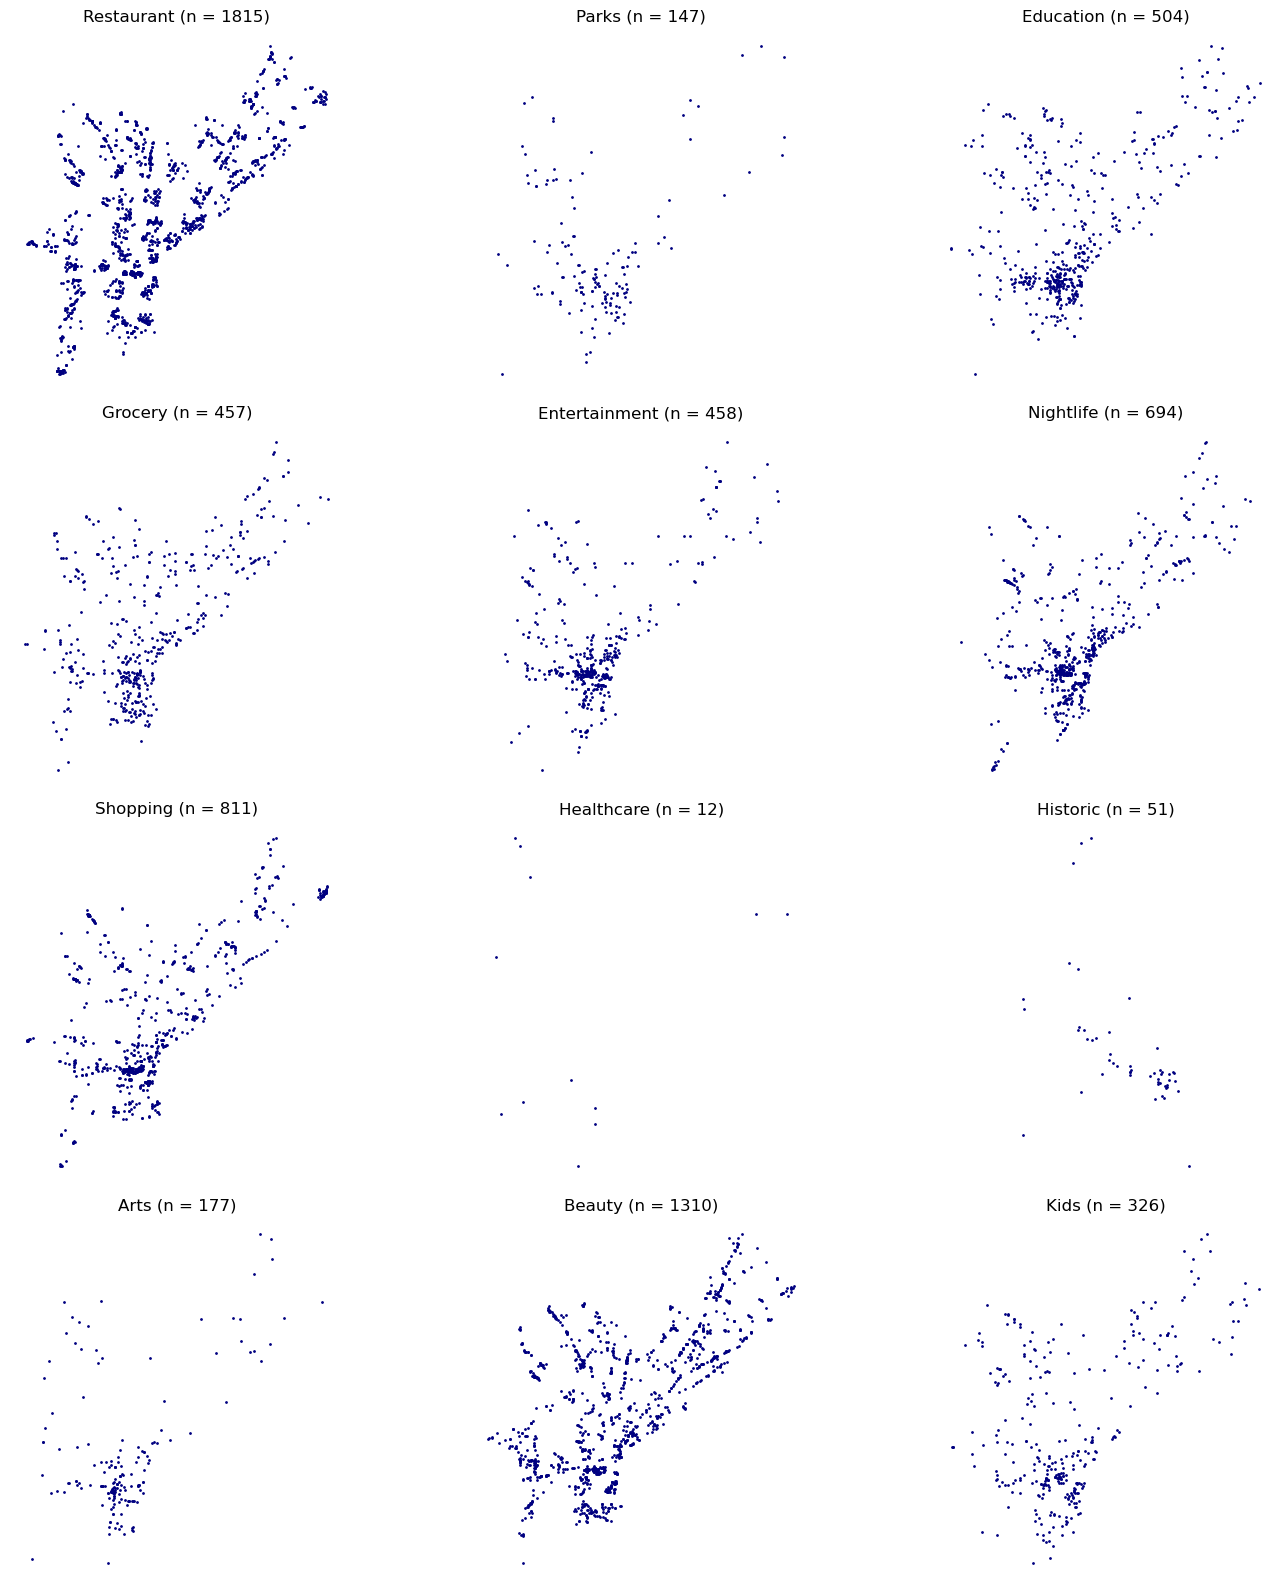

In [1104]:
# Extract unique business types
business_types = amenities_phl_gdf['type'].unique()

# Determine the number of rows and columns for the subplots
n_rows = len(business_types) // 3 + (len(business_types) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))

# Flatten the axes array for easy looping
axes = axes.flatten()

# Create a map for each business type
for i, business_type in enumerate(business_types):
    # Filter data for the current business type
    subset = amenities_phl_gdf[amenities_phl_gdf['type'] == business_type]

    # Get count for the current business type
    count = amenities_grouped[amenities_grouped['type'] == business_type]['count'].values[0]

    # Plotting with transparency
    subset.plot(ax=axes[i], color='navy', markersize=1, alpha=1)

    # Set title with count (n = count)
    axes[i].set_title(f"{business_type.capitalize()} (n = {count})")

    # Customizations: Remove boxes, axis ticks, and labels
    axes[i].set_axis_off()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Display the panel of maps
plt.show()

## Intersect with neighborhoods

In [1105]:
amenities_neighborhood = gpd.sjoin(amenities_phl_gdf, neigh, how = "left", predicate = "intersects")

In [1106]:
amenities_neighborhood.head()

name  rating           address  \
0            Gunpowder Cafe     3.0               NaN   
1  Lucky Chinese Restaurant     0.0  5541 Chester Ave   
2      Chester Family Pizza     2.5  5504 Chester Ave   
3                  Nas Cafe     0.0  5405 Chester Ave   
4             Kan Yuen Ping     0.0  5428 Chester Ave   

                                 alias                                  title  \
0  fooddeliveryservices, indpak, cafes  Food Delivery Services, Indian, Cafes   
1                              chinese                                Chinese   
2                                pizza                                  Pizza   
3                                cafes                                  Cafes   
4                          restaurants                            Restaurants   

                         geometry          desc_1  desc_2 desc_3        type  \
0  POINT (2676022.529 232162.402)          indpak  indpak  cafes  restaurant   
1  POINT (2676286.873 230415.145)         chinese     NaN    NaN  restaurant   
2  POINT (2676648.905 230553.397)           pizza     NaN    NaN  restaurant   
3  POINT (2676904.285 231029.670)  bakeries/cafes     NaN    NaN  restaurant   
4  POINT (2676791.167 230669.291)         chinese     NaN    NaN  restaurant   

   index_right  area_mi2      nb_name  
0          132  1.032126  Kingsessing  
1          132  1.032126  Kingsessing  
2          132  1.032126  Kingsessing  
3          132  1.032126  Kingsessing  
4          132  1.032126  Kingsessing

In [1107]:
amenities_neigh_group = amenities_neighborhood.groupby(["nb_name", "type"]).size().reset_index(name='count')

In [1108]:
amenities_neigh_group.head()

nb_name           type  count
0  Academy Gardens         beauty      6
1  Academy Gardens      education      2
2  Academy Gardens  entertainment      2
3  Academy Gardens        grocery      1
4  Academy Gardens           kids      1

In [1109]:
amenities_neigh_total = amenities_neigh_group.groupby("nb_name")['count'].sum().reset_index(name='total_amenities')

In [1110]:
amenities_neigh_total.head()

nb_name  total_amenities
0   Academy Gardens               22
1           Airport               61
2    Allegheny West               56
3           Andorra               19
4  Aston-Woodbridge                8

In [1111]:
amenities_neigh_group = amenities_neigh_group.merge(amenities_neigh_total, on="nb_name", how="left")

In [1112]:
amenities_neigh_group.head()

nb_name           type  count  total_amenities
0  Academy Gardens         beauty      6               22
1  Academy Gardens      education      2               22
2  Academy Gardens  entertainment      2               22
3  Academy Gardens        grocery      1               22
4  Academy Gardens           kids      1               22

In [1113]:
amenities_neigh_group["pct_share"] = (100*amenities_neigh_group["count"]/amenities_neigh_group["total_amenities"]).round(1)

In [1114]:
amenities_neigh_group.head()

nb_name           type  count  total_amenities  pct_share
0  Academy Gardens         beauty      6               22       27.3
1  Academy Gardens      education      2               22        9.1
2  Academy Gardens  entertainment      2               22        9.1
3  Academy Gardens        grocery      1               22        4.5
4  Academy Gardens           kids      1               22        4.5

In [1115]:
amenities_neigh_group_gdf = amenities_neigh_group.merge(neigh, on = "nb_name", how = "left")

In [1116]:
amenities_neigh = gpd.GeoDataFrame(amenities_neigh_group_gdf, geometry='geometry')

In [1117]:
amenities_nb = amenities_neigh[["nb_name", "type", "count", "total_amenities", "pct_share", "geometry", "area_mi2"]]

In [1118]:
amenities_nb = amenities_nb.copy()
amenities_nb.loc[:, 'count_per_mi2'] = amenities_nb['count'] / amenities_nb['area_mi2']

In [1119]:
amenities_nb[amenities_nb["type"] == "kids"].explore(tiles='CartoDB dark_matter', legend=True, column = "pct_share", cmap = "magma")

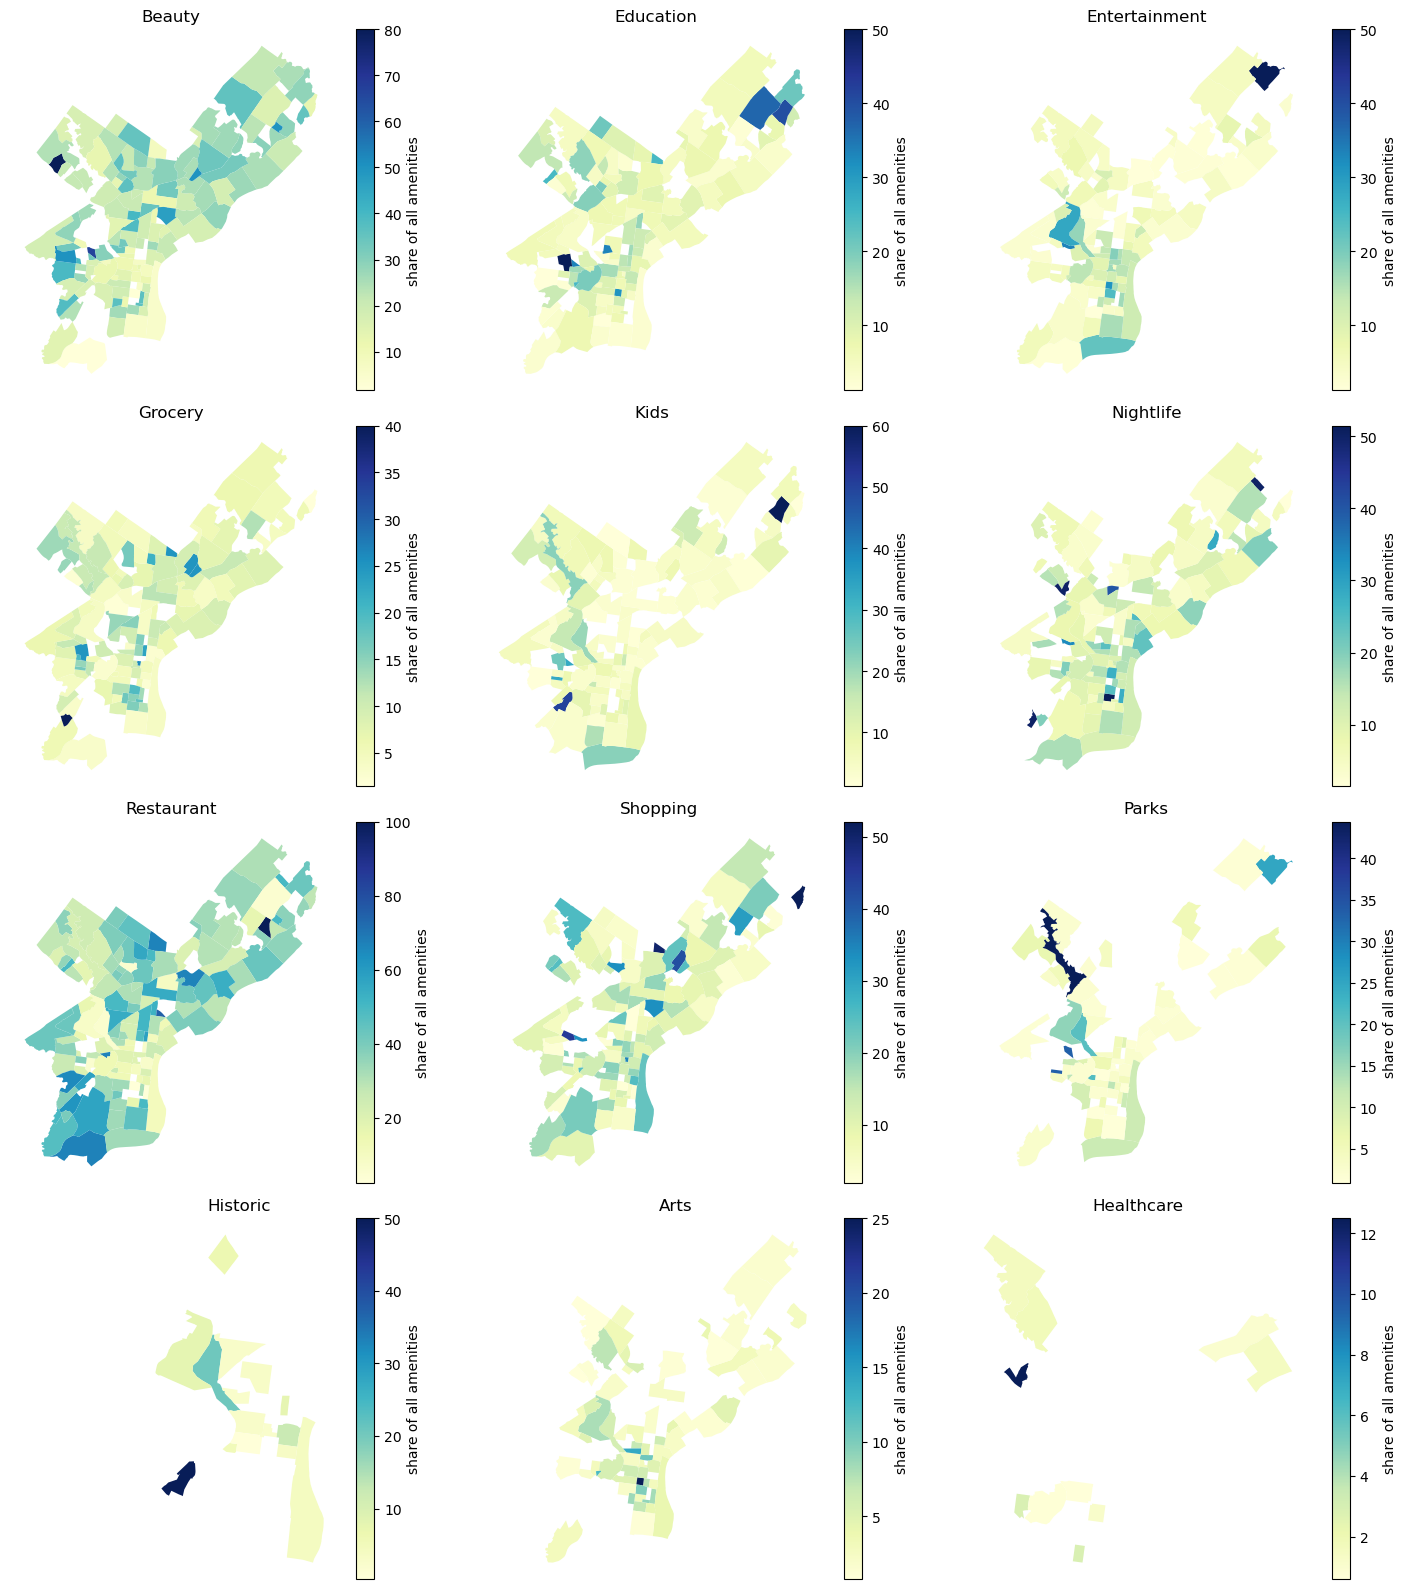

In [1120]:
# Extract unique types
amenity_types = amenities_nb['type'].unique()

# Determine the number of rows and columns for the subplots
n_rows = len(amenity_types) // 3 + (len(amenity_types) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))

# Flatten the axes array for easy looping
axes = axes.flatten()

# Create a choropleth map for each amenity type
for i, amenity_type in enumerate(amenity_types):
    # Filter data for the current amenity type
    subset = amenities_nb[amenities_nb['type'] == amenity_type]

    # Plotting
    subset.plot(column='pct_share', ax=axes[i], legend=True,
                legend_kwds={'label': "share of all amenities"},
                cmap='YlGnBu')

    # Set title
    axes[i].set_title(amenity_type.capitalize())
    
     # Remove boxes, axis ticks, and axis labels
    axes[i].set_axis_off()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Display the panel of maps
plt.show()

In [1121]:
amenities_nb.to_file('amenities_neigh.geojson', driver='GeoJSON', index=False)

## Correlation analysis

In [1122]:
# spreading the data
amenities_nb_wide = amenities_nb.pivot_table(index='nb_name', columns='type', values='pct_share', aggfunc=np.mean).fillna(0)

In [1123]:
# Calculating the correlation matrix
correlation_matrix = amenities_nb_wide.corr()

import altair as alt

# Reset index to convert the index into a column for Altair
heatmap_data = correlation_matrix.reset_index().melt('type', var_name='type2', value_name='correlation')

# Create the heatmap
heatmap = alt.Chart(heatmap_data).mark_rect().encode(
    x='type:N',
    y='type2:N',
    color='correlation:Q'
)

# Add text to each cell
text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation > 0.75, 
        alt.value('white'),
        alt.value('black')
    )
)

# Display the chart
chart = (heatmap + text).properties(width=600, height=600)
chart

alt.LayerChart(...)

# Cluster analysis

In [1124]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Overall (all features)

In [1125]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

In [1126]:
amenities_nb_wide = amenities_nb.pivot_table(index='nb_name', columns='type', values='pct_share', fill_value=0).reset_index()

In [1127]:
amenities_nb_scaled = scaler.fit_transform(amenities_nb_wide[["arts", "education", "kids", "nightlife", "parks", "restaurant", "shopping"]])

In [1128]:
amenities_nb_scaled[:5]

array([[-0.57794679,  0.14926393, -0.15135435, -0.01048566, -0.4437252 ,
        -0.06703338, -0.08815405],
       [-0.57794679, -0.92493936, -0.69537104,  0.69895844, -0.4437252 ,
         2.00822975, -0.02153764],
       [-0.57794679, -0.0868247 , -0.47776436, -0.54499833, -0.16425187,
         1.1136301 ,  0.06411203],
       [-0.57794679,  0.31452598, -0.05464027,  0.12557212, -0.4437252 ,
         0.42707689, -0.44978598],
       [-0.57794679, -0.92493936, -0.69537104, -0.89486118, -0.4437252 ,
         3.71421046, -0.95416737]])

In [1129]:
amenities_nb_scaled.mean(axis=0)

array([-3.50596745e-17,  2.92163954e-17,  6.28152501e-17,  1.75298372e-17,
        2.48339361e-17, -5.84327908e-17, -7.30409885e-17])

In [1130]:
amenities_nb_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

In [1131]:
# Perform the fit
kmeans.fit(amenities_nb_scaled)

# Extract the labels
amenities_nb_wide['label'] = kmeans.labels_

In [1132]:
(
    alt.Chart(amenities_nb_wide)
    .mark_circle()
    .encode(
        alt.X("restaurant:Q", scale=alt.Scale(zero=False)),
        alt.Y("education:Q", scale=alt.Scale(zero=False)),
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(amenities_nb_wide.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

In [1133]:
amenities_nb_wide.groupby("label").size()

label
0    80
1    27
2     4
3    35
4     6
dtype: int64

In [1134]:
# Average restaurants per cluster
amenities_nb_wide.groupby("label")['restaurant'].mean().sort_values()

label
2     0.000000
1     8.829630
4     9.066667
3    18.377143
0    42.618750
Name: restaurant, dtype: float64

In [1135]:
# Average educational institutions per cluster
amenities_nb_wide.groupby("label")['parks'].mean().sort_values()

label
2     0.000000
0     1.318750
3     1.442857
1     3.729630
4    29.616667
Name: parks, dtype: float64

In [1136]:
amenities_clusters = amenities_nb_wide.merge(neigh, how = "left", on = "nb_name")
amenities_clusters_gdf = gpd.GeoDataFrame(amenities_clusters, geometry = "geometry")

In [1137]:
amenities_clusters_gdf.explore(
    column="label",
    cmap="Set3",
    categorical=True,
    legend=True,
    tiles="CartoDB positron"
)

In [1138]:
amenities_clusters_gdf.to_file('clusters.geojson', driver='GeoJSON', index=False)

In [1139]:
cluster_profile = amenities_nb_wide.groupby("label")[["arts", "education", "kids", "nightlife", "parks", "restaurant", "shopping"]].mean()

cluster_profile

type       arts  education       kids  nightlife      parks  restaurant  \
label                                                                     
0      0.805000   6.900000   4.276250   7.538750   1.318750   42.618750   
1      7.096296  12.351852   5.318519  16.866667   3.729630    8.829630   
2      0.000000  30.825000  42.075000   0.000000   0.000000    0.000000   
3      1.008571   5.054286   3.668571   9.342857   1.442857   18.377143   
4      0.983333   0.883333  15.316667   2.350000  29.616667    9.066667   

type    shopping  
label             
0       4.962500  
1      11.200000  
2       0.000000  
3      23.082857  
4       2.783333

6


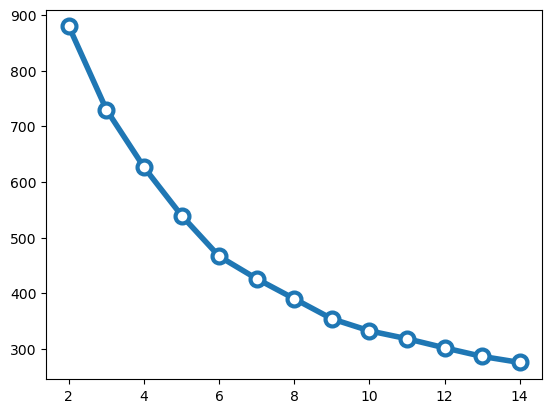

In [1140]:
# Number of clusters to try out
n_clusters = list(range(2, 15))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(amenities_nb_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3);

from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

## Restaurants

In [1141]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)

In [1142]:
food_neigh = food_desc.sjoin(neigh, how = "left")

In [1143]:
restaurant = food_desc[["name", "desc_1"]]
nb_gdf = amenities_neighborhood[["nb_name", "name", "rating"]]

restaurants_nb_gdf = restaurant.merge(nb_gdf, on = "name", how = "left")

In [1144]:
restaurants_nb_grouped = restaurants_nb_gdf.groupby(["nb_name", "desc_1"]).size().reset_index(name="count")

# Sort within each neighborhood group by count in descending order
restaurants_nb_grouped = restaurants_nb_grouped.sort_values(by=["nb_name", "count"], ascending=[True, False])
restaurants_nb_grouped.head()

nb_name    desc_1  count
1  Academy Gardens  fastfood      8
0  Academy Gardens   chinese      4
2  Academy Gardens     pizza      1
3  Academy Gardens   seafood      1
4  Academy Gardens    venues      1

In [1145]:
restaurants_nb_wide = restaurants_nb_grouped.pivot(index='nb_name', columns='desc_1', values='count').reset_index().fillna(0)

# Calculating the correlation matrix
correlation_matrix = restaurants_nb_wide.corr()

import altair as alt

# Reset index to convert the index into a column for Altair
heatmap_data = correlation_matrix.reset_index().melt('desc_1', var_name='desc_2', value_name='correlation')

/var/folders/h_/pxhj6fqj4y3fqkpmr3g9dd3c0000gq/T/ipykernel_3626/2902381521.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = restaurants_nb_wide.corr()


<Axes: >

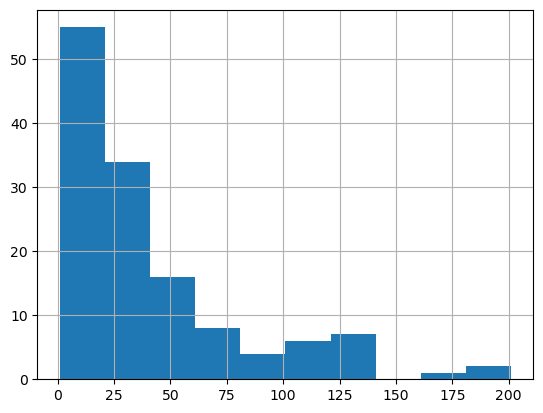

In [1146]:
restaurants_total.hist()

In [1147]:
# Calculating the total restaurants for each neighborhood
restaurants_total = restaurants_nb_wide.set_index('nb_name').sum(axis=1)

# Using 'map' to align and assign the total restaurants back to the original DataFrame
restaurants_nb_wide["total_restaurants"] = restaurants_nb_wide['nb_name'].map(restaurants_total)

restaurants_nb_wide = restaurants_nb_wide[restaurants_nb_wide["total_restaurants"] > 10].copy()

restaurants_nb_wide.head()

desc_1          nb_name  american  asianfusion  bakeries/cafes  bbq  \
0       Academy Gardens       0.0          0.0             0.0  0.0   
1               Airport       2.0          0.0            18.0  0.0   
2        Allegheny West       0.0          0.0             2.0  2.0   
3               Andorra       5.0          1.0             0.0  0.0   
6           Brewerytown       0.0          0.0             6.0  0.0   

desc_1  breakfast_brunch  caribbean  chicken  chinese  cocktailbars  \
0                    0.0        0.0      0.0      4.0           0.0   
1                    4.0        0.0      2.0      0.0           0.0   
2                    0.0        1.0      8.0      6.0           0.0   
3                    0.0        0.0      0.0      1.0           0.0   
6                    1.0        0.0      0.0      3.0           0.0   

desc_1  diner/grill  fastfood  halal  indpak  italian  japanese  korean  \
0               0.0       8.0    0.0     0.0      0.0       0.0     0.0   
1               3.0      46.0    0.0     0.0      4.0       2.0     0.0   
2               0.0      86.0    0.0     0.0      0.0       6.0     0.0   
3               0.0      31.0    0.0     0.0      0.0       0.0     0.0   
6               0.0       0.0    0.0     0.0      0.0       0.0     0.0   

desc_1  latin  mediterranean  pizza  salad  sandwiches/delis  seafood  \
0         0.0            0.0    1.0    0.0               0.0      1.0   
1         5.0            3.0    4.0    7.0               8.0      7.0   
2         0.0            0.0    5.0    0.0               3.0      4.0   
3         0.0            0.0    0.0    1.0              11.0      0.0   
6         0.0            0.0    3.0    0.0               2.0      0.0   

desc_1  soulfood  venues  vietnamese  total_restaurants  
0            0.0     1.0         0.0               15.0  
1            0.0     2.0         0.0              117.0  
2            1.0     0.0         0.0              124.0  
3            0.0     0.0         0.0               50.0  
6            2.0     0.0         0.0               17.0

In [1148]:
# Columns representing different cuisines
cuisine_columns = ['bakeries/cafes', 
                   'chicken', 'chinese', 'diner/grill', 
                   'fastfood', "korean",
                   'pizza', 
                   'sandwiches/delis', 'vietnamese', 'total_restaurants']

# Convert cuisine counts to percentages of the total restaurants
for column in cuisine_columns:
    restaurants_nb_wide[column] = ((restaurants_nb_wide[column] / restaurants_nb_wide['total_restaurants']) * 100).round(2)

# Check the updated DataFrame
restaurants_nb_wide.head()

desc_1          nb_name  american  asianfusion  bakeries/cafes  bbq  \
0       Academy Gardens       0.0          0.0            0.00  0.0   
1               Airport       2.0          0.0           15.38  0.0   
2        Allegheny West       0.0          0.0            1.61  2.0   
3               Andorra       5.0          1.0            0.00  0.0   
6           Brewerytown       0.0          0.0           35.29  0.0   

desc_1  breakfast_brunch  caribbean  chicken  chinese  cocktailbars  \
0                    0.0        0.0     0.00    26.67           0.0   
1                    4.0        0.0     1.71     0.00           0.0   
2                    0.0        1.0     6.45     4.84           0.0   
3                    0.0        0.0     0.00     2.00           0.0   
6                    1.0        0.0     0.00    17.65           0.0   

desc_1  diner/grill  fastfood  halal  indpak  italian  japanese  korean  \
0              0.00     53.33    0.0     0.0      0.0       0.0     0.0   
1              2.56     39.32    0.0     0.0      4.0       2.0     0.0   
2              0.00     69.35    0.0     0.0      0.0       6.0     0.0   
3              0.00     62.00    0.0     0.0      0.0       0.0     0.0   
6              0.00      0.00    0.0     0.0      0.0       0.0     0.0   

desc_1  latin  mediterranean  pizza  salad  sandwiches/delis  seafood  \
0         0.0            0.0   6.67    0.0              0.00      1.0   
1         5.0            3.0   3.42    7.0              6.84      7.0   
2         0.0            0.0   4.03    0.0              2.42      4.0   
3         0.0            0.0   0.00    1.0             22.00      0.0   
6         0.0            0.0  17.65    0.0             11.76      0.0   

desc_1  soulfood  venues  vietnamese  total_restaurants  
0            0.0     1.0         0.0              100.0  
1            0.0     2.0         0.0              100.0  
2            1.0     0.0         0.0              100.0  
3            0.0     0.0         0.0              100.0  
6            2.0     0.0         0.0              100.0

In [1149]:
# Create the heatmap
heatmap = alt.Chart(heatmap_data).mark_rect().encode(
    x='desc_1:N',
    y='desc_2:N',
    color='correlation:Q'
)

# Add text to each cell
text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

# Display the chart
chart = (heatmap + text).properties(width=1000, height=1000)
chart

alt.LayerChart(...)

In [1150]:
restaurants_nb_scaled = scaler.fit_transform(restaurants_nb_wide[['bakeries/cafes', 
                   'chicken', 'chinese', 'diner/grill', 
                   'fastfood', "korean",
                   'pizza', 
                   'sandwiches/delis', 'vietnamese', 'total_restaurants']])

In [1151]:
restaurants_nb_scaled[:5]
restaurants_nb_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [1152]:
restaurants_nb_scaled.mean(axis=0)

array([-3.77948264e-17, -5.19678863e-17,  1.86021411e-17,  1.00392508e-16,
       -1.02754684e-16,  2.42123106e-17, -1.25195362e-16,  1.27557539e-16,
        4.72435330e-18,  0.00000000e+00])

In [1153]:
# Perform the fit
kmeans.fit(restaurants_nb_scaled)

# Extract the labels
restaurants_nb_wide['label'] = kmeans.labels_

In [1154]:
(
    alt.Chart(restaurants_nb_wide)
    .mark_circle()
    .encode(
        alt.X("bakeries/cafes:Q", scale=alt.Scale(zero=False)),
        alt.Y("chinese:Q", scale=alt.Scale(zero=False)),
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(restaurants_nb_wide.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

In [1155]:
restaurants_nb_wide.groupby("label").size()

label
0    21
1     2
2     4
3    43
4     4
5     1
6    15
7     4
dtype: int64

In [1156]:
# Average restaurants per cluster
restaurants_nb_wide.groupby("label")['bakeries/cafes'].mean().sort_values()

label
1     0.000000
3     2.634419
7     3.032500
0     5.221429
4     6.295000
5    11.110000
2    11.255000
6    25.364667
Name: bakeries/cafes, dtype: float64

In [1157]:
restaurants_clusters = restaurants_nb_wide.merge(neigh, how = "left", on = "nb_name")
restaurants_clusters_gdf = gpd.GeoDataFrame(restaurants_clusters, geometry = "geometry")

In [1158]:
restaurants_clusters_gdf.explore(
    column="label",
    cmap="Set3",
    categorical=True,
    legend=True,
    tiles="CartoDB positron"
)

In [1159]:
food_profile = restaurants_nb_wide.groupby("label")[['bakeries/cafes', 
                   'chicken', 'chinese', 'diner/grill', 
                   'fastfood', "korean",
                   'pizza', 
                   'sandwiches/delis', 'vietnamese']].mean().round()

food_profile

desc_1  bakeries/cafes  chicken  chinese  diner/grill  fastfood  korean  \
label                                                                     
0                  5.0      3.0      4.0          3.0      38.0     0.0   
1                  0.0     66.0      7.0          0.0       0.0     0.0   
2                 11.0      5.0     10.0          2.0      19.0     0.0   
3                  3.0      1.0      5.0          0.0      69.0     0.0   
4                  6.0      1.0     39.0          0.0       0.0     0.0   
5                 11.0      0.0      0.0          6.0      39.0     6.0   
6                 25.0      2.0      4.0          0.0      20.0     0.0   
7                  3.0      8.0      5.0          6.0       0.0     0.0   

desc_1  pizza  sandwiches/delis  vietnamese  
label                                        
0         9.0              13.0         0.0  
1         9.0               2.0         0.0  
2        11.0              15.0         3.0  
3         5.0               7.0         0.0  
4        19.0              19.0         0.0  
5         0.0               0.0         0.0  
6        13.0               9.0         0.0  
7        25.0              32.0         0.0

In [1160]:
restaurants_clusters_gdf.to_file('food_clusters.geojson', driver='GeoJSON', index=False)

7


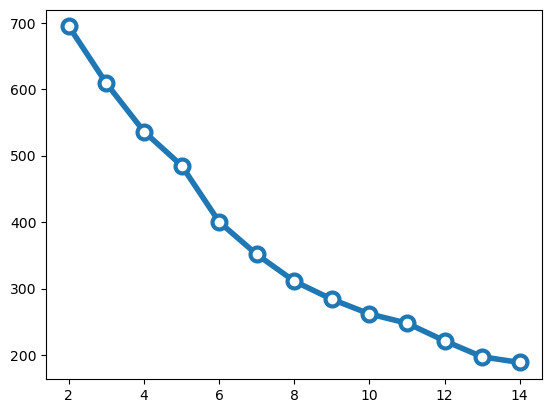

In [1161]:
# Number of clusters to try out
n_clusters = list(range(2, 15))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(restaurants_nb_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3);

from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

## Nightlife

In [1162]:
nightlife = night_desc[["name", "desc_1"]]
nb_gdf = amenities_neighborhood[["nb_name", "name", "rating"]]

nightlife_nb_gdf = nightlife.merge(nb_gdf, on = "name", how = "left")

In [1163]:
nightlife_nb_grouped = nightlife_nb_gdf.groupby(["nb_name", "desc_1"]).size().reset_index(name="count")

# Sort within each neighborhood group by count in descending order
nightlife_nb_grouped = nightlife_nb_grouped.sort_values(by=["nb_name", "count"], ascending=[True, False])
nightlife_nb_grouped.head(20)

nb_name        desc_1  count
0   Academy Gardens          bars      1
1   Academy Gardens          pubs      1
5           Airport     wine_bars     14
4           Airport    sportsbars      9
2           Airport          bars      4
3           Airport  cocktailbars      3
6    Allegheny West          bars      2
7    Allegheny West      divebars      1
9           Andorra    sportsbars     14
8           Andorra          pubs      1
12      Bella Vista  cocktailbars      4
13      Bella Vista      divebars      3
14      Bella Vista     wine_bars      3
10      Bella Vista          bars      2
11      Bella Vista       beerbar      1
15      Brewerytown          bars      2
16      Brewerytown    sportsbars      2
17       Bridesburg          bars      3
18       Bridesburg      divebars      1
19       Bridesburg          pubs      1

In [1164]:
nightlife_nb_wide = nightlife_nb_grouped.pivot(index='nb_name', columns='desc_1', values='count').fillna(0).reset_index()

In [1165]:
nightlife_nb_scaled = scaler.fit_transform(nightlife_nb_wide[['bars', 'beerbar', 'cocktailbars', 'divebars', 'lounges', 'musicvenues', 'pubs',
                                                             'sportsbars', 'wine_bars']])

In [1166]:
nightlife_nb_scaled[:5]
nightlife_nb_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [1167]:
nightlife_nb_scaled.mean(axis=0)

array([ 5.39833214e-17, -2.13896179e-17,  3.11295332e-17, -4.07421293e-17,
        1.01855323e-17, -1.68061284e-17,  6.11131940e-18,  8.65770249e-18,
        3.25937035e-17])

In [1168]:
# Perform the fit
kmeans.fit(nightlife_nb_scaled)

# Extract the labels
nightlife_nb_wide['label'] = kmeans.labels_

In [1169]:
(
    alt.Chart(nightlife_nb_wide)
    .mark_circle()
    .encode(
        alt.X("bars:Q", scale=alt.Scale(zero=False)),
        alt.Y("musicvenues:Q", scale=alt.Scale(zero=False)),
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(nightlife_nb_wide.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

In [1170]:
nightlife_nb_wide.groupby("label").size()

label
0      9
1     53
2      1
3      1
4      2
5      1
6      1
7      2
8      5
9      3
10    10
11     1
12     9
13    11
dtype: int64

In [1171]:
nightlife_clusters = nightlife_nb_wide.merge(tract, how = "left", on = "nb_name")
nightlife_clusters_gdf = gpd.GeoDataFrame(nightlife_clusters, geometry = "geometry")

In [1172]:
nightlife_clusters_gdf.explore(
    column="label",
    cmap="Set3",
    categorical=True,
    legend=True,
    tiles="CartoDB positron"
)

/Users/annaduan/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/array.py:968: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/Users/annaduan/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/array.py:969: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/Users/annaduan/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/array.py:970: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/Users/annaduan/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/array.py:971: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: Location values cannot contain NaNs.

# District profiles

In [1173]:
clusters = gpd.read_file("data/clusters.geojson")
districts = gpd.read_file("data/Planning_Districts.geojson")[["DIST_NAME", "geometry"]]
districts_proj = districts.to_crs(2272)

cluster_ctr = clusters.copy()
cluster_ctr.geometry = cluster_ctr.geometry.centroid

In [1174]:
tract_dist = cluster_ctr.sjoin(districts_proj)

In [1175]:
district_profile = tract_dist.groupby("DIST_NAME")[['arts', 'beauty', 'education', 'entertainment', 'grocery', 
                                   'healthcare', 'historic', 'kids', 'nightlife', 'parks', 
                                   'restaurant', 'shopping']].mean()

district_profile.to_csv('district_profile.csv', index=False)

district_profile

arts     beauty  education  entertainment  \
DIST_NAME                                                             
Central               5.331579  11.152632   9.994737      12.452632   
Central Northeast     0.625000  28.050000   4.475000       0.850000   
Lower Far Northeast   0.500000  20.558333  10.858333       2.366667   
Lower North           1.781818  19.118182   9.100000       4.800000   
Lower Northeast       0.000000  27.800000   2.800000       0.300000   
Lower Northwest       0.466667  22.522222   9.966667       3.811111   
Lower South           0.366667   8.100000   1.766667      14.600000   
Lower Southwest       0.414286  10.914286   2.228571       1.557143   
North                 0.209091  23.318182   6.372727       1.763636   
North Delaware        1.220000  24.700000   4.840000       2.320000   
River Wards           2.480000  20.820000   5.580000       6.220000   
South                 4.315385  19.176923   4.876923       7.392308   
University Southwest  2.072727  12.481818   9.654545       3.872727   
Upper Far Northeast   1.100000  27.266667   3.833333      19.966667   
Upper North           0.475000  20.425000  10.575000       1.350000   
Upper Northwest       2.200000  22.281818   8.554545       4.463636   
West                  0.133333  34.511111  11.833333       2.255556   
West Park             4.180000  12.520000   3.920000      15.880000   

                        grocery  healthcare  historic       kids  nightlife  \
DIST_NAME                                                                     
Central                7.284211    0.094737  1.942105   5.894737  12.963158   
Central Northeast      4.925000    0.000000  0.000000   9.450000  11.250000   
Lower Far Northeast    3.150000    0.000000  0.000000   7.000000   8.858333   
Lower North            8.163636    0.000000  2.418182   4.263636   5.790909   
Lower Northeast       13.020000    0.000000  0.000000   3.340000   2.300000   
Lower Northwest        7.566667    1.388889  0.000000   4.655556  11.611111   
Lower South            1.100000    0.000000  0.000000  15.133333  11.966667   
Lower Southwest        8.800000    0.000000  0.000000   0.985714  13.357143   
North                  3.781818    0.000000  0.000000   1.309091  12.609091   
North Delaware         6.420000    0.500000  0.000000   4.560000  10.400000   
River Wards            8.260000    0.000000  0.000000   2.940000  14.580000   
South                 11.361538    0.223077  0.315385   6.500000  14.200000   
University Southwest   5.663636    0.318182  4.545455  11.063636   7.063636   
Upper Far Northeast    4.066667    0.000000  0.000000   2.766667   3.033333   
Upper North           10.650000    0.000000  0.000000   2.100000   2.100000   
Upper Northwest        6.809091    0.300000  0.581818   7.018182   3.054545   
West                   9.477778    0.000000  0.000000   8.433333   4.422222   
West Park              5.440000    0.000000  1.600000   5.780000  11.420000   

                         parks  restaurant   shopping  
DIST_NAME                                              
Central               3.842105   14.989474  14.063158  
Central Northeast     1.575000   32.325000   6.500000  
Lower Far Northeast   0.000000   36.966667   9.716667  
Lower North           3.509091   34.509091   6.572727  
Lower Northeast       0.000000   31.580000  18.840000  
Lower Northwest       1.922222   27.311111   8.777778  
Lower South           6.133333   37.266667   3.533333  
Lower Southwest       0.414286   52.242857   9.028571  
North                 0.418182   37.890909  12.372727  
North Delaware        1.980000   37.180000   5.880000  
River Wards           1.540000   27.220000  10.340000  
South                 3.815385   20.215385   7.607692  
University Southwest  6.618182   27.900000   8.754545  
Upper Far Northeast   8.900000   22.300000   6.733333  
Upper North           0.000000   42.362500   9.925000  
Upper Northwest       4.818182   30.345455   9.581818  
West            